Run CCC analysis using LIANA+Tensorcell2cell to analyse communication between T cells (except gd) and DCs in the ABC, DT_ABC, and aCD4_ABC contexts

TODO: if LR pairs popping up don't make sense. The parameter that makes the most difference is return_all, so should compare those two outputs. Can also tune specificity filter (maybe don't use) as well as the lr_fill (use NaN), but these don't seem to make as big a difference. 

- return_all = TRUE seems to generate the 4 factor tensor, with 3 being context specific and loadings being not specific
- return_all = FALSE seems to generate a 9-10 factor tensor, but none are especially context specific

can also try out scoring method as gmean, suggested by EArmingol

In [1]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
    gpu_use = F
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
    gpu_use = T
}

library(reticulate, quietly = T)
if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

n.cores<-30
env_name = 'norcross_abc'

In [2]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(liana, quietly = T)
        library(decoupleR, quietly = T)

        library(Seurat, quietly = T)
        
        library(dplyr, quietly = T)
        library(tidyr, quietly = T)
        library(magrittr, quietly = T)
        library(tibble, quietly = T)
        library(reshape2, quietly = T)
        library(stringr)
        library(plyr, quietly = T)
        library(textshape, quietly = T)

        library(ggplot2, quietly = T)
        library(circlize, quietly = T)
        library(RColorBrewer, quietly = T)
        
        library(clusterProfiler, quietly = T)
        
        # library(textshape, quietly = T)
        c2c <- reticulate::import(module = "cell2cell", as="c2c")
    })
})

Set the pipeline parameters (things we can potentially adjust to get different outputs):

In [3]:
params<-list(return_all = FALSE, #whether to return all LRs in liana after filtering for expr_prop
             filter_specificity = FALSE, # whether to filter scores by specificty
             filter_thresh = 0.05, # specificity filter threshold
             filter_specificity_how = 'fill', # or exclude -- fill insignifanct interactions with min or remove alltogether
             lr_fill_by = NaN, # or 0 or NaN -- what to use in the lr_fill tc2c argument
             how = 'outer' # what to use in the how tc2c argument
            )

Load the data:

In [4]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Subset to the cell types and contexts of interest:

In [5]:
cell.types<-c('T-cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2', 'pDC')
contexts<-c('ABC', 'DT_ABC', 'aCD4_ABC')
abc.ccc<-subset(abc.integrated, subset = (Cell.Type.Level1 %in% cell.types) & (Cell.Type.Level2 != 'gd-T') &
                                        (orig.ident %in% contexts))
Idents(abc.ccc)<-'Cell.Type.Level2'

Format to input to LIANA:

In [6]:
# format into sce object
DefaultAssay(abc.ccc)<-'RNA'
abc.ccc@meta.data <-abc.ccc@meta.data %>% droplevels()
abc.ccc.sce<-Seurat::as.SingleCellExperiment(abc.ccc)

In [7]:
# map LIANA consensus resource to mouse
suppressMessages({
    suppressWarnings({
        op_resource <- liana::select_resource("Consensus")[[1]]

        # Generate orthologous resource
        ortholog_resource <- liana::generate_homologs(op_resource = op_resource,
                                               target_organism = 10090) # mouse
    })
})

Run liana for each context and calculate the consensus rank score:

In [8]:
# suppressWarnings({
#     abc.ccc.sce<-liana_bysample(sce = abc.ccc.sce, 
#                idents_col = 'Cell.Type.Level2', 
#                sample_col = 'orig.ident',
#                assay.type='logcounts', # log-normalized counts
#                verbose = T, 
#               aggregate_how = 'both', # consensus magnitude AND specifity score
#                 resource = 'custom', 
#                 external_resource = ortholog_resource, # consensus resource in mouse
#                min_cells = 5, # default min cells to be considered
#                expr_prop = 0.05, # expressed in atleast 5% of cells to be scored
#                return_all = params$return_all, # assign a low score to those that don't pass expr_prop
#                 parallelize = TRUE, workers = n.cores,
#               )
# })
# saveRDS(abc.ccc.sce@metadata$liana_res, paste0(data_path, 'interim/', 'liana_bysample.rds'))

abc.ccc.sce@metadata$liana_res<-readRDS(paste0(data_path, 'interim/', 'liana_bysample.rds'))

If filtering for specificity rank, will change # of interactions in the contexts as follows:

In [9]:
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x)[[1]])
       
if (params$filter_specificity_how == 'exclude'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank <= params$filter_thresh, ])[[1]])
    }else if (params$filter_specificity_how == 'fill'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank > params$filter_thresh, ])[[1]])
    }


ABC   DT_ABC aCD4_ABC 
   41796    37634    39221

ABC   DT_ABC aCD4_ABC 
   33553    30985    31142

In [10]:
if (params$filter_specificity){
    liana_res<-list()
    for (sample.name in names(abc.ccc.sce@metadata$liana_res)){
        x<-abc.ccc.sce@metadata$liana_res[[sample.name]]
        if (params$filter_specificity_how == 'exclude'){
            x<-x[x$specificity_rank <= params$filter_thresh, ] # eliminate those under threshold
        }else if (params$filter_specificity_how == 'fill'){
            x[x$specificity_rank > params$filter_thresh, 'magnitude_rank']<-max(x$magnitude_rank) # replace with "lowest" value (max because magnitude rank orders lower values as higher importance)
        }
        abc.ccc.sce@metadata$liana_res[[sample.name]]<-x
    }
}

Run Tensor-cell2cell

In [11]:
abc.ccc.sce@metadata$liana_res<-liana:::preprocess_scores(context_df_dict = abc.ccc.sce@metadata$liana_res, 
                                 score_col = 'magnitude_rank', # score to preprocess
                                  outer_fraction = 1/3, # only keep cells/LRs present in atleast in 1/3 of contexts
                                                        # outer_fract shouldn't change things since there are only 3 samples
                                  invert = TRUE, # since magnitude has lower scores being more valuable
                                  invert_fun = function(x) 1-x, 
                                  non_negative = TRUE, # shouldn't effect things since all magnitude ranks are positive
                                  non_negative_fill = 0, 
                                  verbose = T
                                 )

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!



In [12]:
score_col = 'magnitude_rank'

if (params$lr_fill_by == 'min'){
    lr.fill.value<-min(sapply(abc.ccc.sce@metadata$liana_res, function(x) min(x[[score_col]])))
}else if (is.numeric(params$lr_fill_by)){
    lr.fill.value<-params$lr_fill_by
}
lr.fill.value

[1] NaN

In [13]:
# # build tensor
# tensor <- liana::liana_tensor_c2c(sce = abc.ccc.sce,
#                                   context_df_dict = NULL, 
#                                   score_col = 'magnitude_rank', 
#                                   how = params$how, 
#                                   lr_fill = lr.fill.value,
#                                   cell_fill = 0, 
#                                   context_order = levels(abc.ccc.sce@colData$orig.ident), 
#                                   sort_elements = TRUE, 
#                                   conda_env = env_name, 
#                                   build_only = TRUE, 
#                                   device = device)

# # decompose tensor
# tensor<-liana::decompose_tensor(tensor = tensor, 
#                          rank = NULL, 
#                          tf_optimization = 'regular', # CHANGE TO ROBUST
#                          elbow_metric = 'error', # Metric to use in the elbow analysis.
#                          smooth_elbow = FALSE, # Whether smoothing the metric of the elbow analysis.
#                          upper_rank=25, # Max number of factors to try in the elbow analysis
#                          init = 'svd', # Initialization method of the tensor factorization
#                          factors_only = FALSE, 
#                         )
# reticulate::py_save_object(object = tensor, 
#                            filename = paste0(paste0(data_path, 'processed/', 'ccc_tensor.pkl')))

tensor<-reticulate::py_load_object(paste0(paste0(data_path, 'processed/', 'ccc_tensor.pkl')))

# Downstream Analysis

In [14]:
write.csv(tensor$factors$interactions, 
          paste0(data_path, 'interim/', 'lr_loadings.csv'))

In [14]:
# basic formatting
factors<-liana:::format_c2c_factors(tensor$factors)

# ordering categories
f.c<-factors$contexts
f.c[['context']]<-factor(f.c$context, levels(abc.ccc.sce@colData$orig.ident))
factors[['contexts']]<-f.c
for (ct in c('senders', 'receivers')){
    f.ct<-factors[[ct]]
    f.ct[['celltype']]<-factor(f.ct$celltype, levels(abc.ccc.sce@colData$Cell.Type.Level2))
    factors[[ct]]<-f.ct
}
abc.ccc.sce@metadata$tensor_res<-factors

abc.ccc.sce@colData[['group']] = abc.ccc.sce@colData[['orig.ident']] # must have a "group" for plotting

[1] "The identified tensor rank is 10"


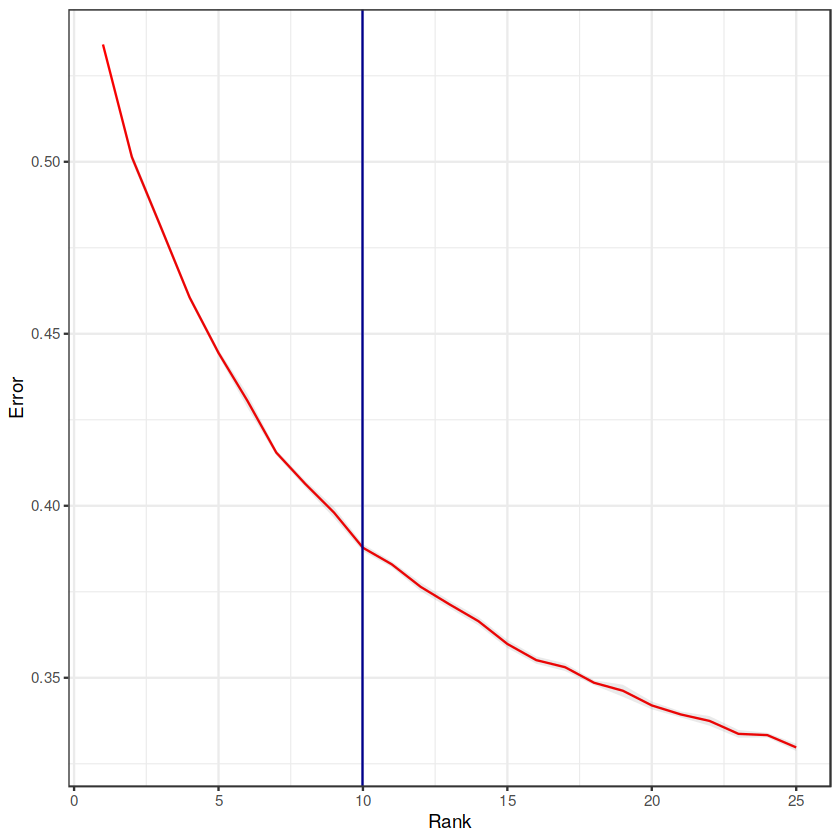

In [15]:
print(paste0('The identified tensor rank is ', tensor$rank))

# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    mutate(rank=row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    group_by(rank) %>%
    summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

In [16]:
# addapt from liana
plot_c2c_overview <- function(sce, group_col, sample_col, factors.of.interest=NULL){

    factors <- get_c2c_factors(sce, group_col, sample_col)
    if (is.null(factors.of.interest)){
        factors.of.interest<-names(which(sapply(names(factors$contexts), function(x) startsWith(x, 'Factor.'))))
    }

    # Contexts
    contexts <- factors$contexts %>%
        pivot_longer(cols = -c("context", group_col),
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=context, y=loadings, fill=.data[[group_col]])) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Contexts') +
        ylab(NULL)

    # lr
    lr <- factors$interactions %>%
        pivot_longer(-lr, names_to = "factor", values_to = "loadings") %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=lr, y=loadings)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ ., scales = "free_y") +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Interactions') +
        ylab(NULL)


    # Sender cells
    senders <- factors$senders %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Senders')

    # Receiver cells
    receivers <- factors$receivers %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              strip.background = element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_text(size=15, face = "bold"),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Receivers')

    # Assemble overview plot
    overview <- patchwork::wrap_plots(list(contexts,
                                           lr,
                                           senders,
                                           receivers
    ),
    ncol=4,
    nrow(1)) +
        patchwork::plot_layout(guides = "collect")

    grid::grid.draw(overview)
}

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(group_col)

  # Now:
  data %>% select(all_of(group_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


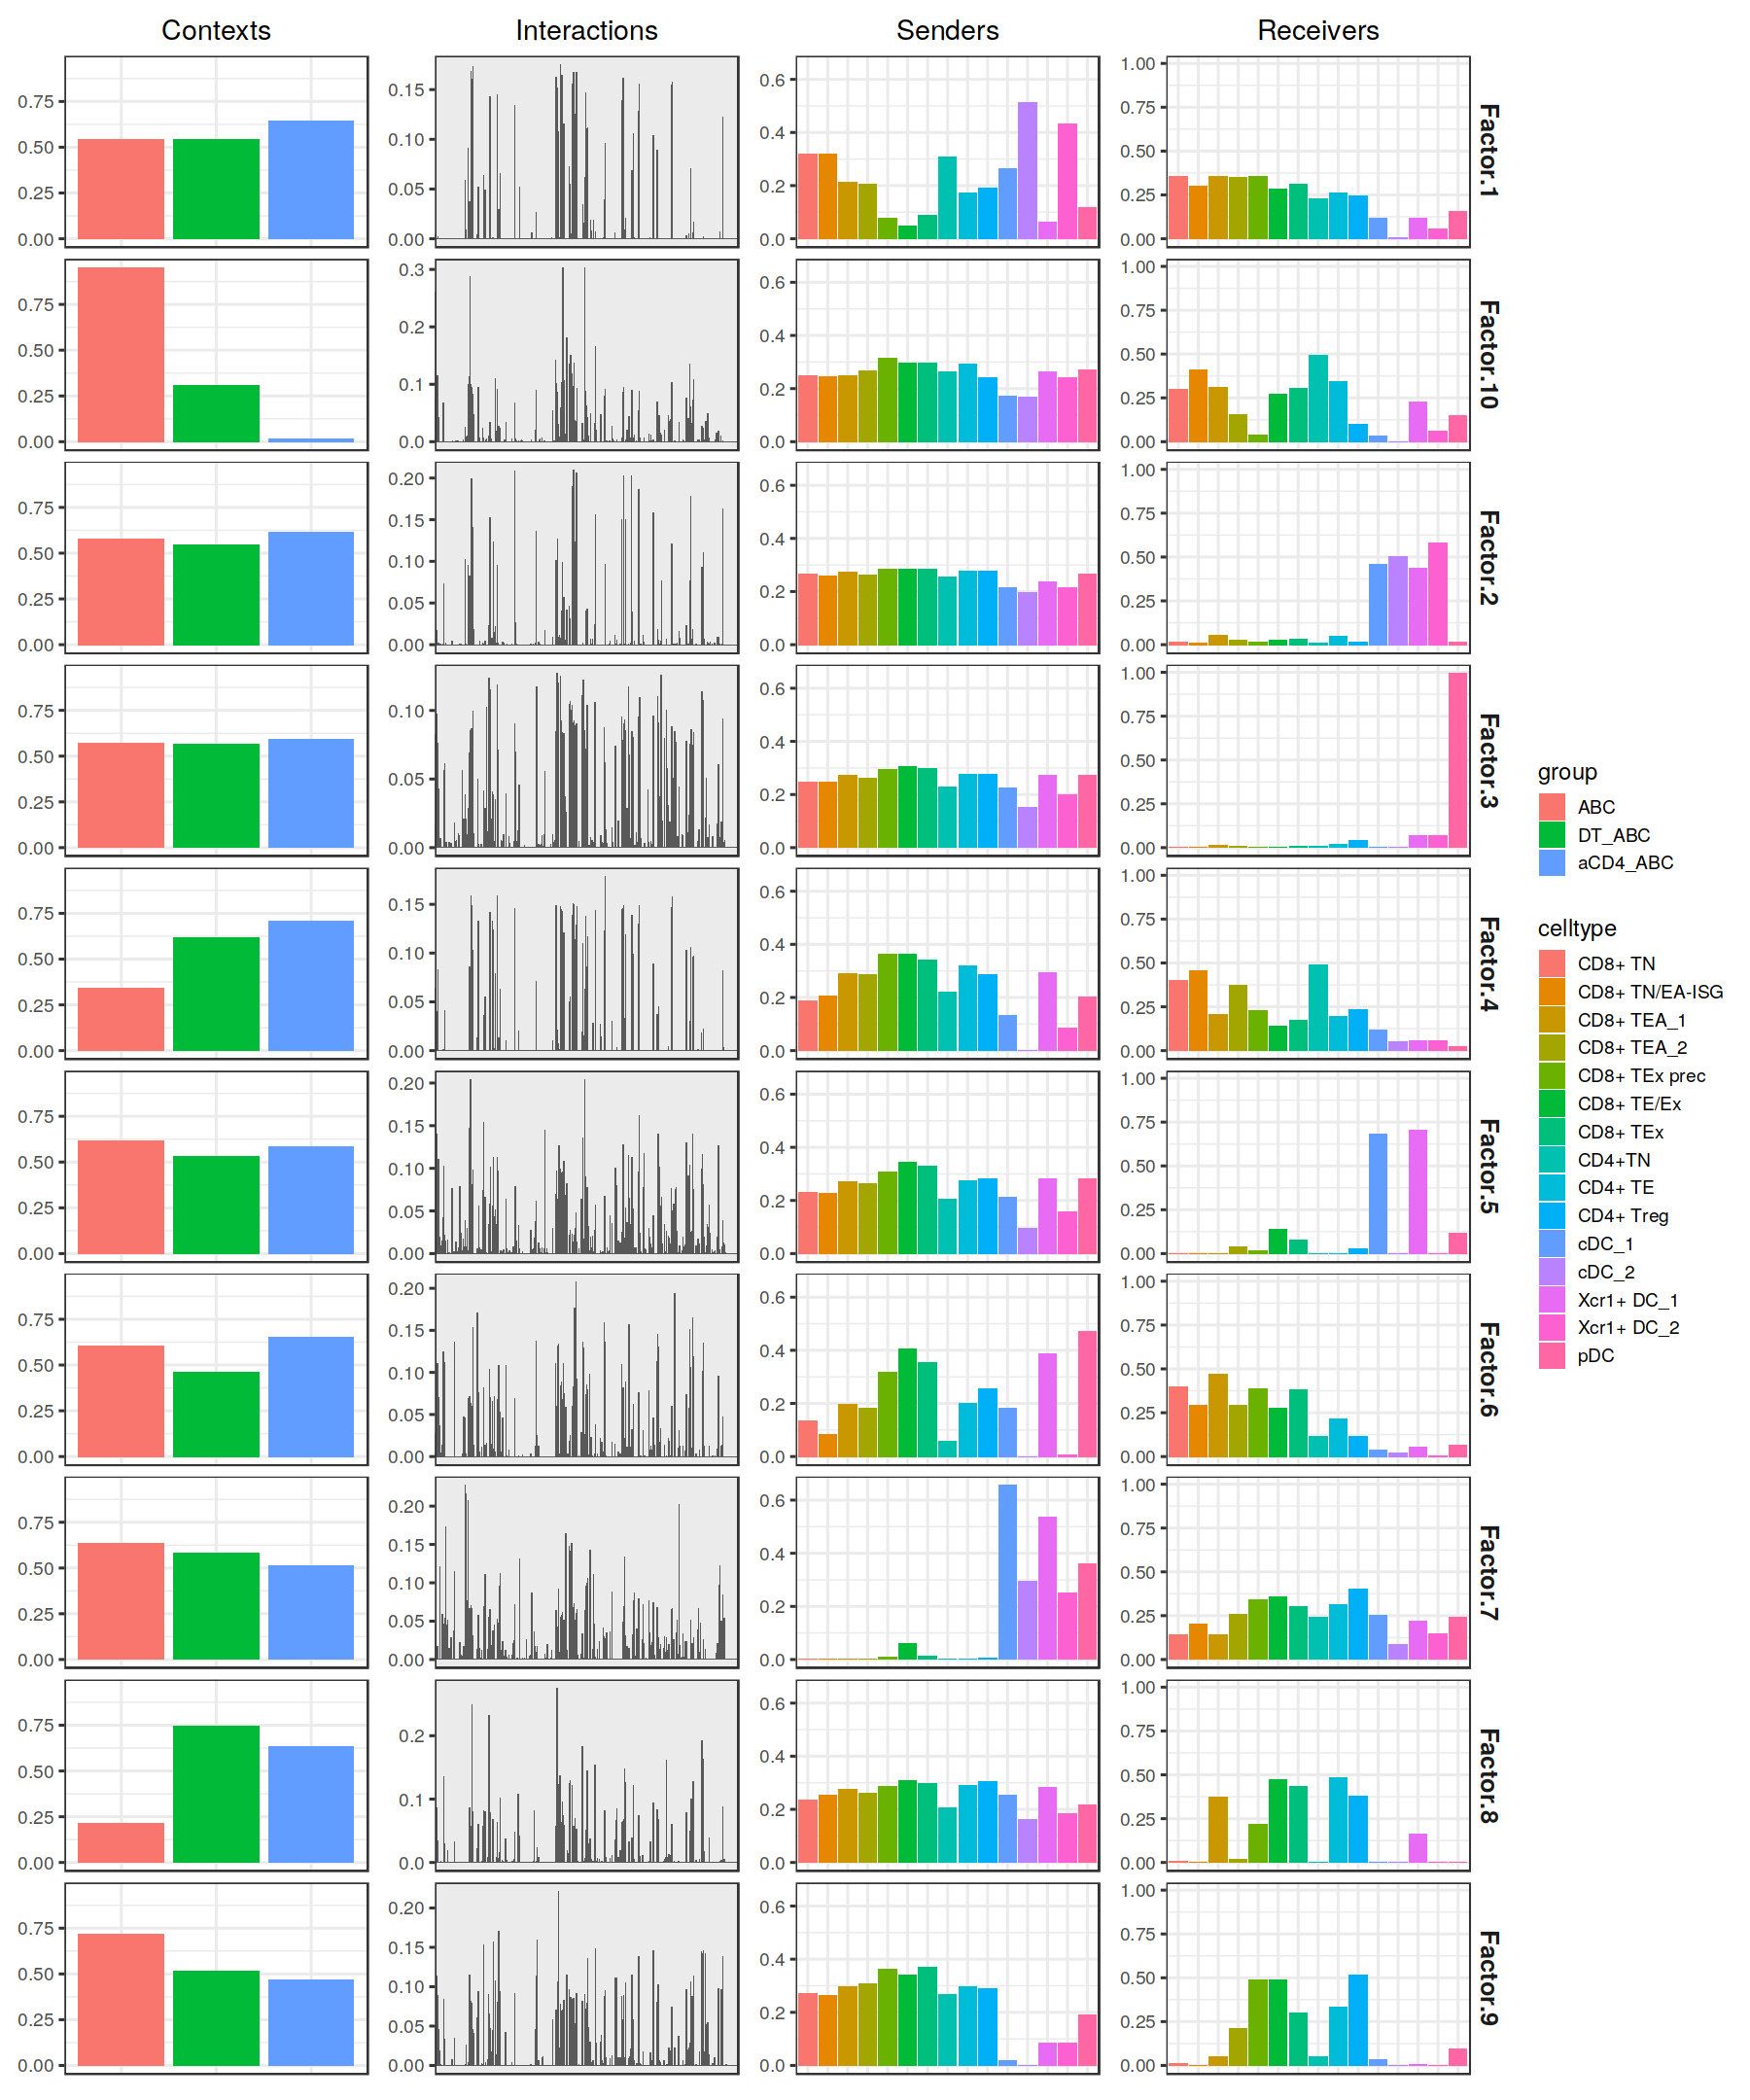

In [17]:
h_ = 18
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident')

**When using rank all = FALSE**:
General conclusions: 3 of the 4 factors (Factors 1-3) represent a single-context specific communication pattern. Receivers tend to be non-specific, whereas senders seem to be specific to a given context. cDCs are the main DC involved in a context-specific manner as senders. However, in a context-independent manner (Factor 4) as senders and as receivers across all Factors all DCs are clearly participating in communication. 

Some interesting sender + context-specific results: CD8 ISG seems specific to aCD4_ABC, TEA_1 is not active in DT_ABC but is in the other two contexts (though this may not align with trajectory analysis results), exhausted CD8s are active as senders in DT_ and aCD4_ABC but not as much in ABC (except TEx), no Tex in aCD4_ABC, some Xcr1 activity in aCD4_ABC but not the other two conditions.  

One unexpected result is that, in the single-context factors, many of the LRs seem to be equally participating (and lower loading values than Factor 4), indicating that perhaps the interactions that are more heavily LR-specific are associated with all contexts and cell types, whereas more subtle differences in which sender cells are expressing LRs dominate Factors 1-3. This may make the results less meaningful. This can also be seen in a heatmap of the LR loadings, where the context-specific factor loadings are weaker and also show substantial overlap:

**When using rank all = TRUE**:
Factors of interest include Factor 10 (ABC-specific), 4 (correlated with context), 8 (DT + aCD4_ABC specific), and 9 (inversely correlated with context) and perhaps 7 (inversely correlated with context). Furthremore, there are some factors that show high specificity for a sender or a receiver (2, 3, 5, 7). There are no Factors specific to DT_ABC or aCD4_ABC alone. Let's focus on Factor 8 for now, which is specific to DT_ABC and aCD4_ABC but not ABC; furthermore, it is slightly stronger in DT_ABC than aCD4_ABC. This can be contrasted with Factor 10 in the future. It looks like this factor is relatively homoegenous for Senders (except some DCs) but only certain receivers are active:

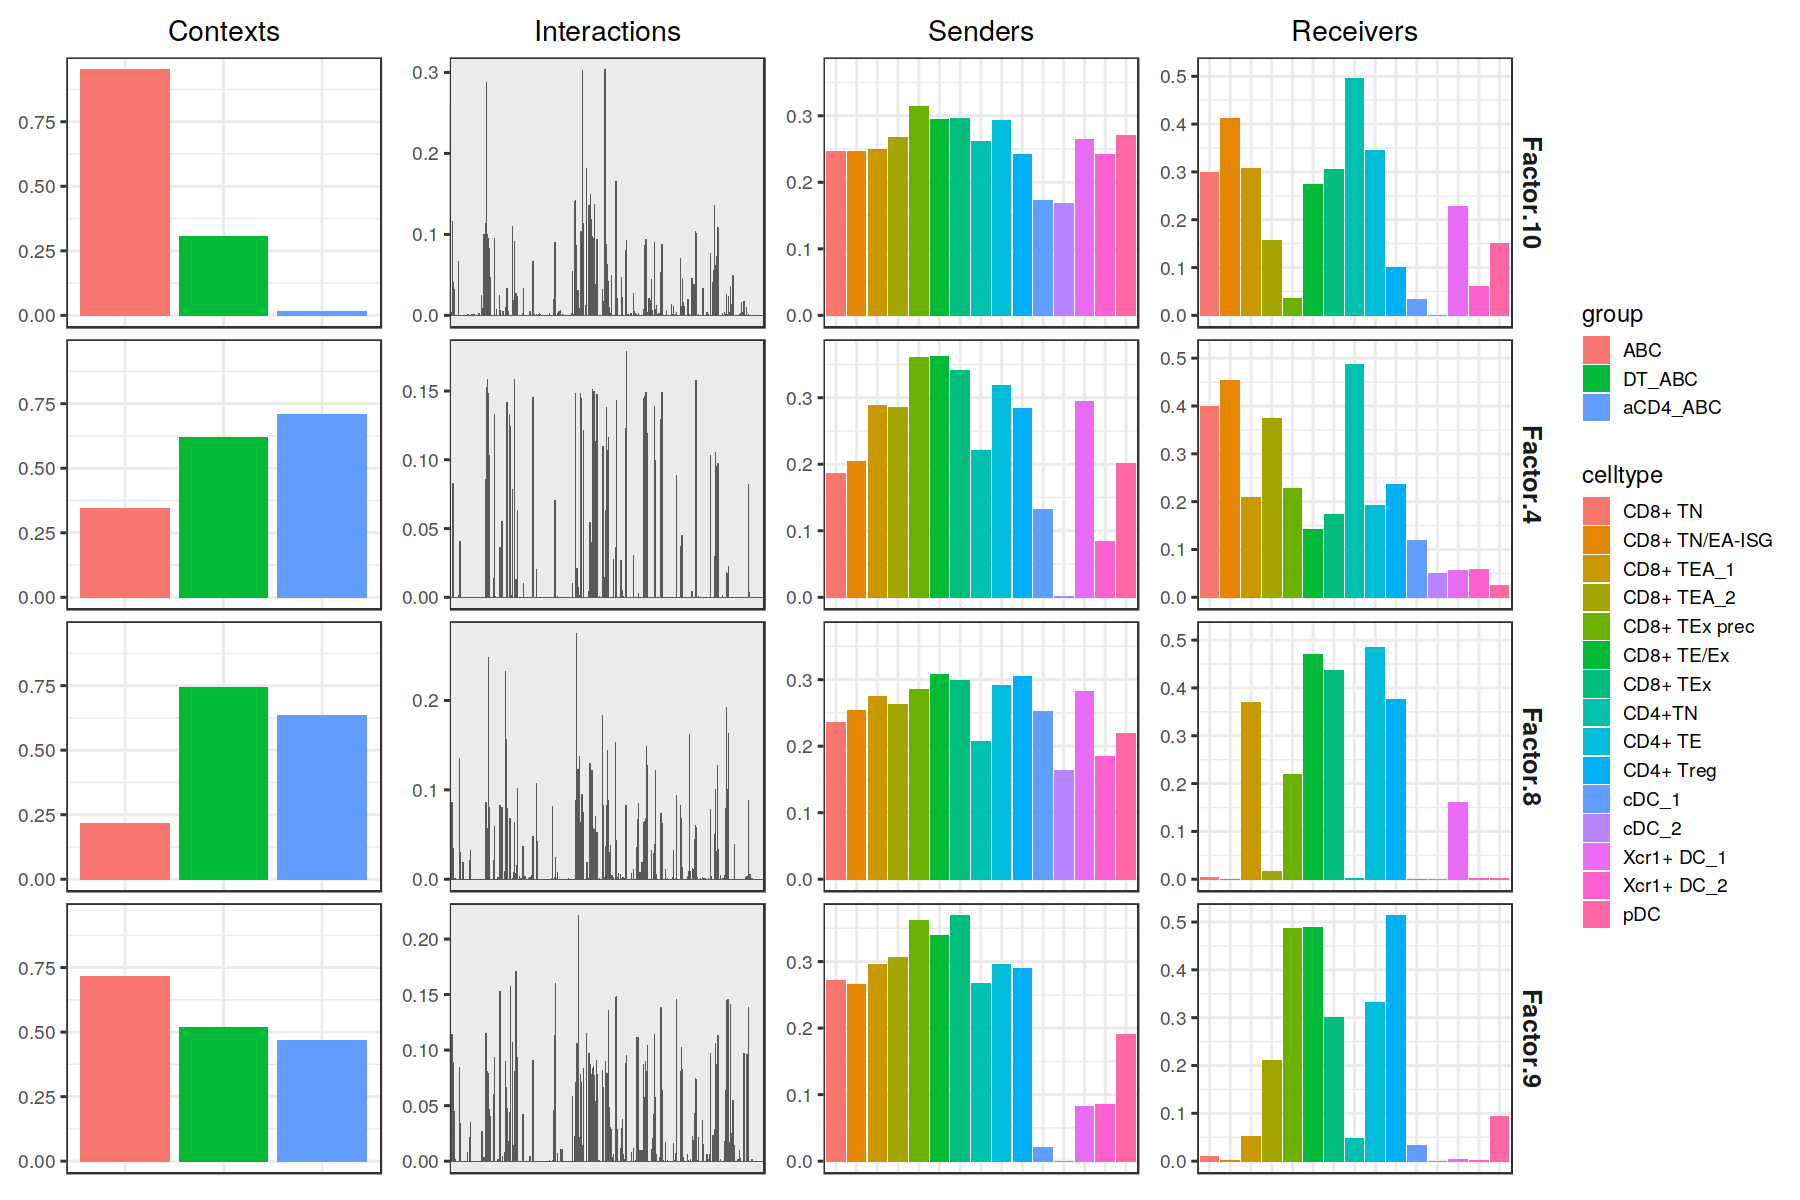

In [18]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
fos<-c('4', '8', '9', '10')
plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident', 
                 factors.of.interest = paste0('Factor.', fos))

In [19]:
fos<-c('4', '8', '9', '10', '2', '3', '5', '7')

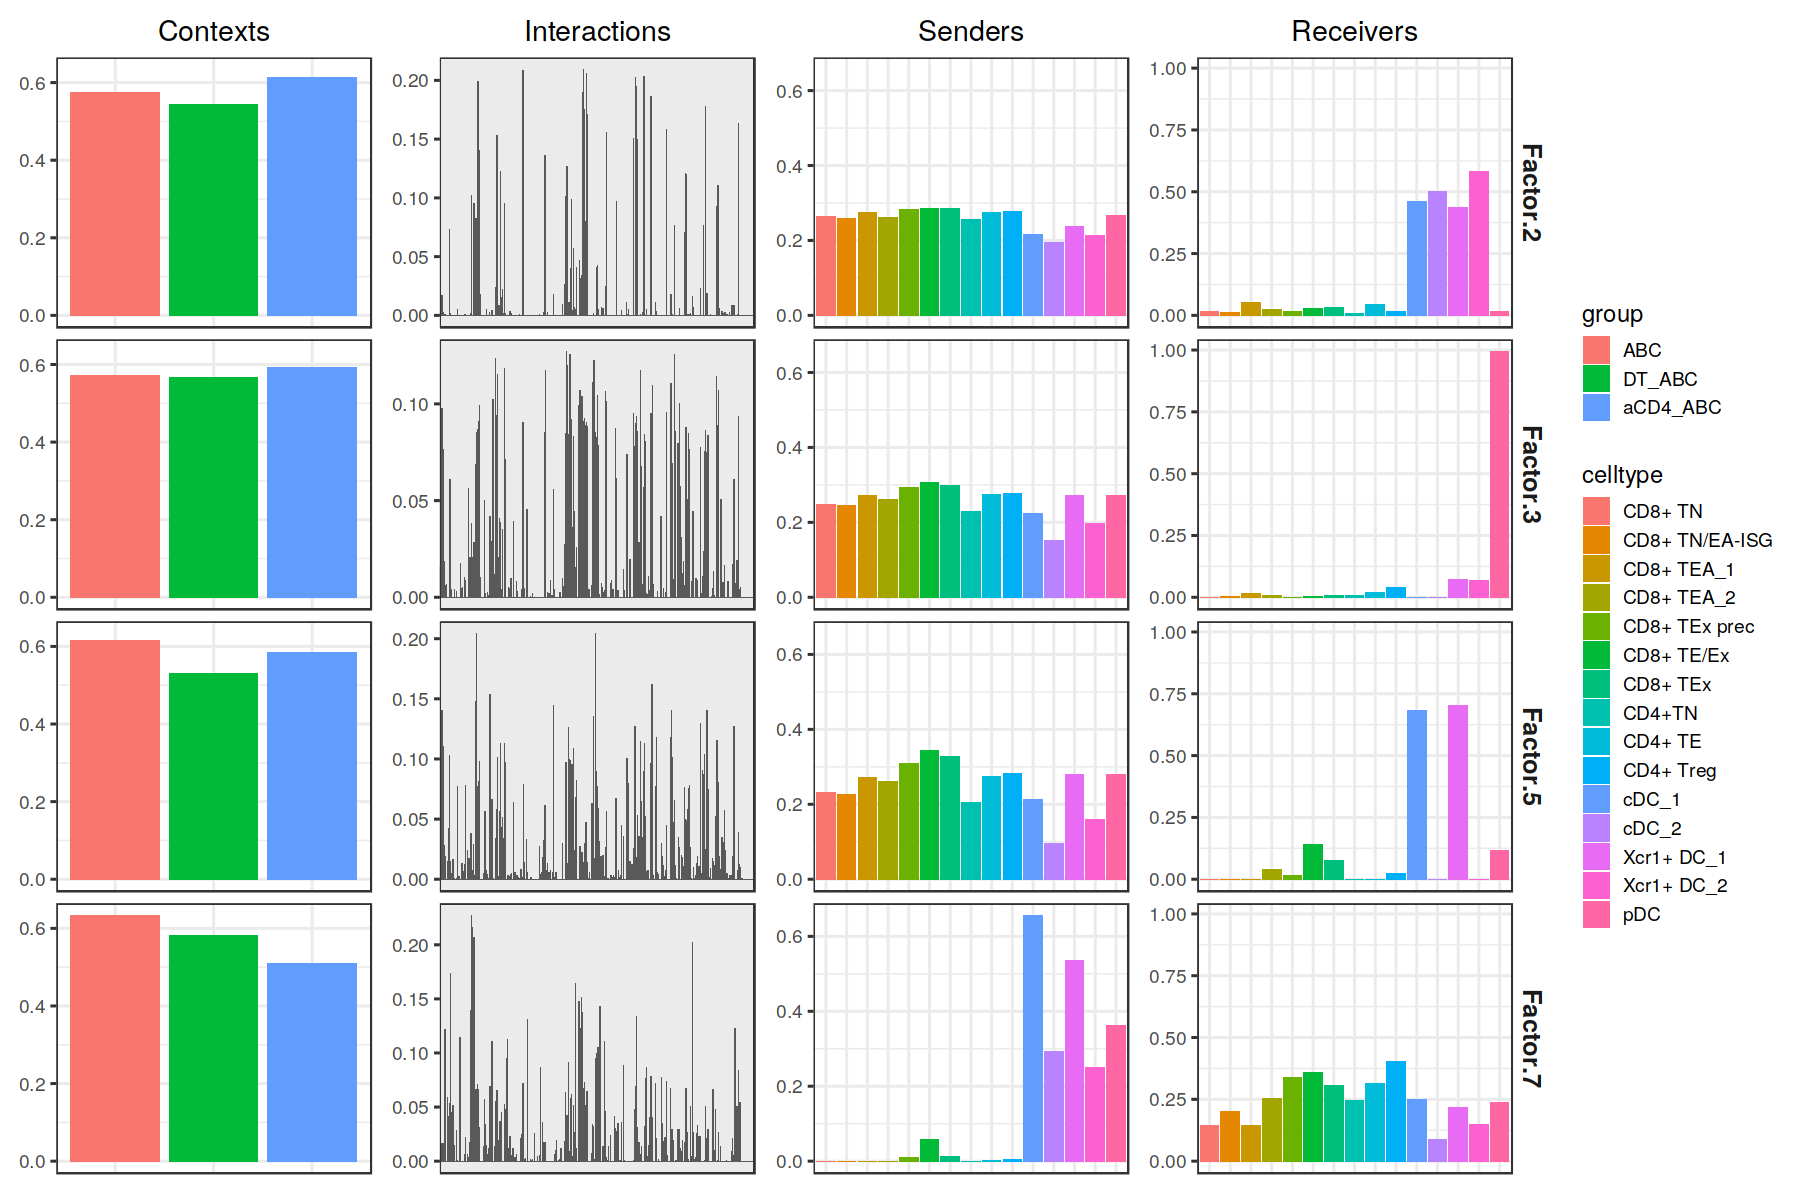

In [20]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
fos<-c('2', '3', '5', '7')
plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident', 
                 factors.of.interest = paste0('Factor.', fos))

In [21]:
calculate_gini(factors$senders) %>% arrange(gini)

factor    gini      
1  Factor.2  0.06126178
2  Factor.10 0.08797348
3  Factor.3  0.08853907
4  Factor.8  0.10160584
5  Factor.5  0.14508426
6  Factor.4  0.25151231
7  Factor.9  0.29906858
8  Factor.1  0.35849930
9  Factor.6  0.40354953
10 Factor.7  0.76214569

Factor 2 is the most homogeneous for sender signaling and Factor 7 is the most heterogeneous for sender signaling. 

In [22]:
calculate_gini(factors$receivers) %>% arrange(gini)

factor    gini     
1  Factor.7  0.2174345
2  Factor.1  0.2888514
3  Factor.4  0.4093516
4  Factor.10 0.4152319
5  Factor.6  0.4497744
6  Factor.9  0.6402761
7  Factor.8  0.6512469
8  Factor.2  0.7040113
9  Factor.5  0.8357347
10 Factor.3  0.9190232

Factor 7 is the most homoegeneous for receiver signaling and Factor 3 is the most heterogeneous for receiver signaling

Quantitatively, both senders and receivers are somewhat heterogeneous.

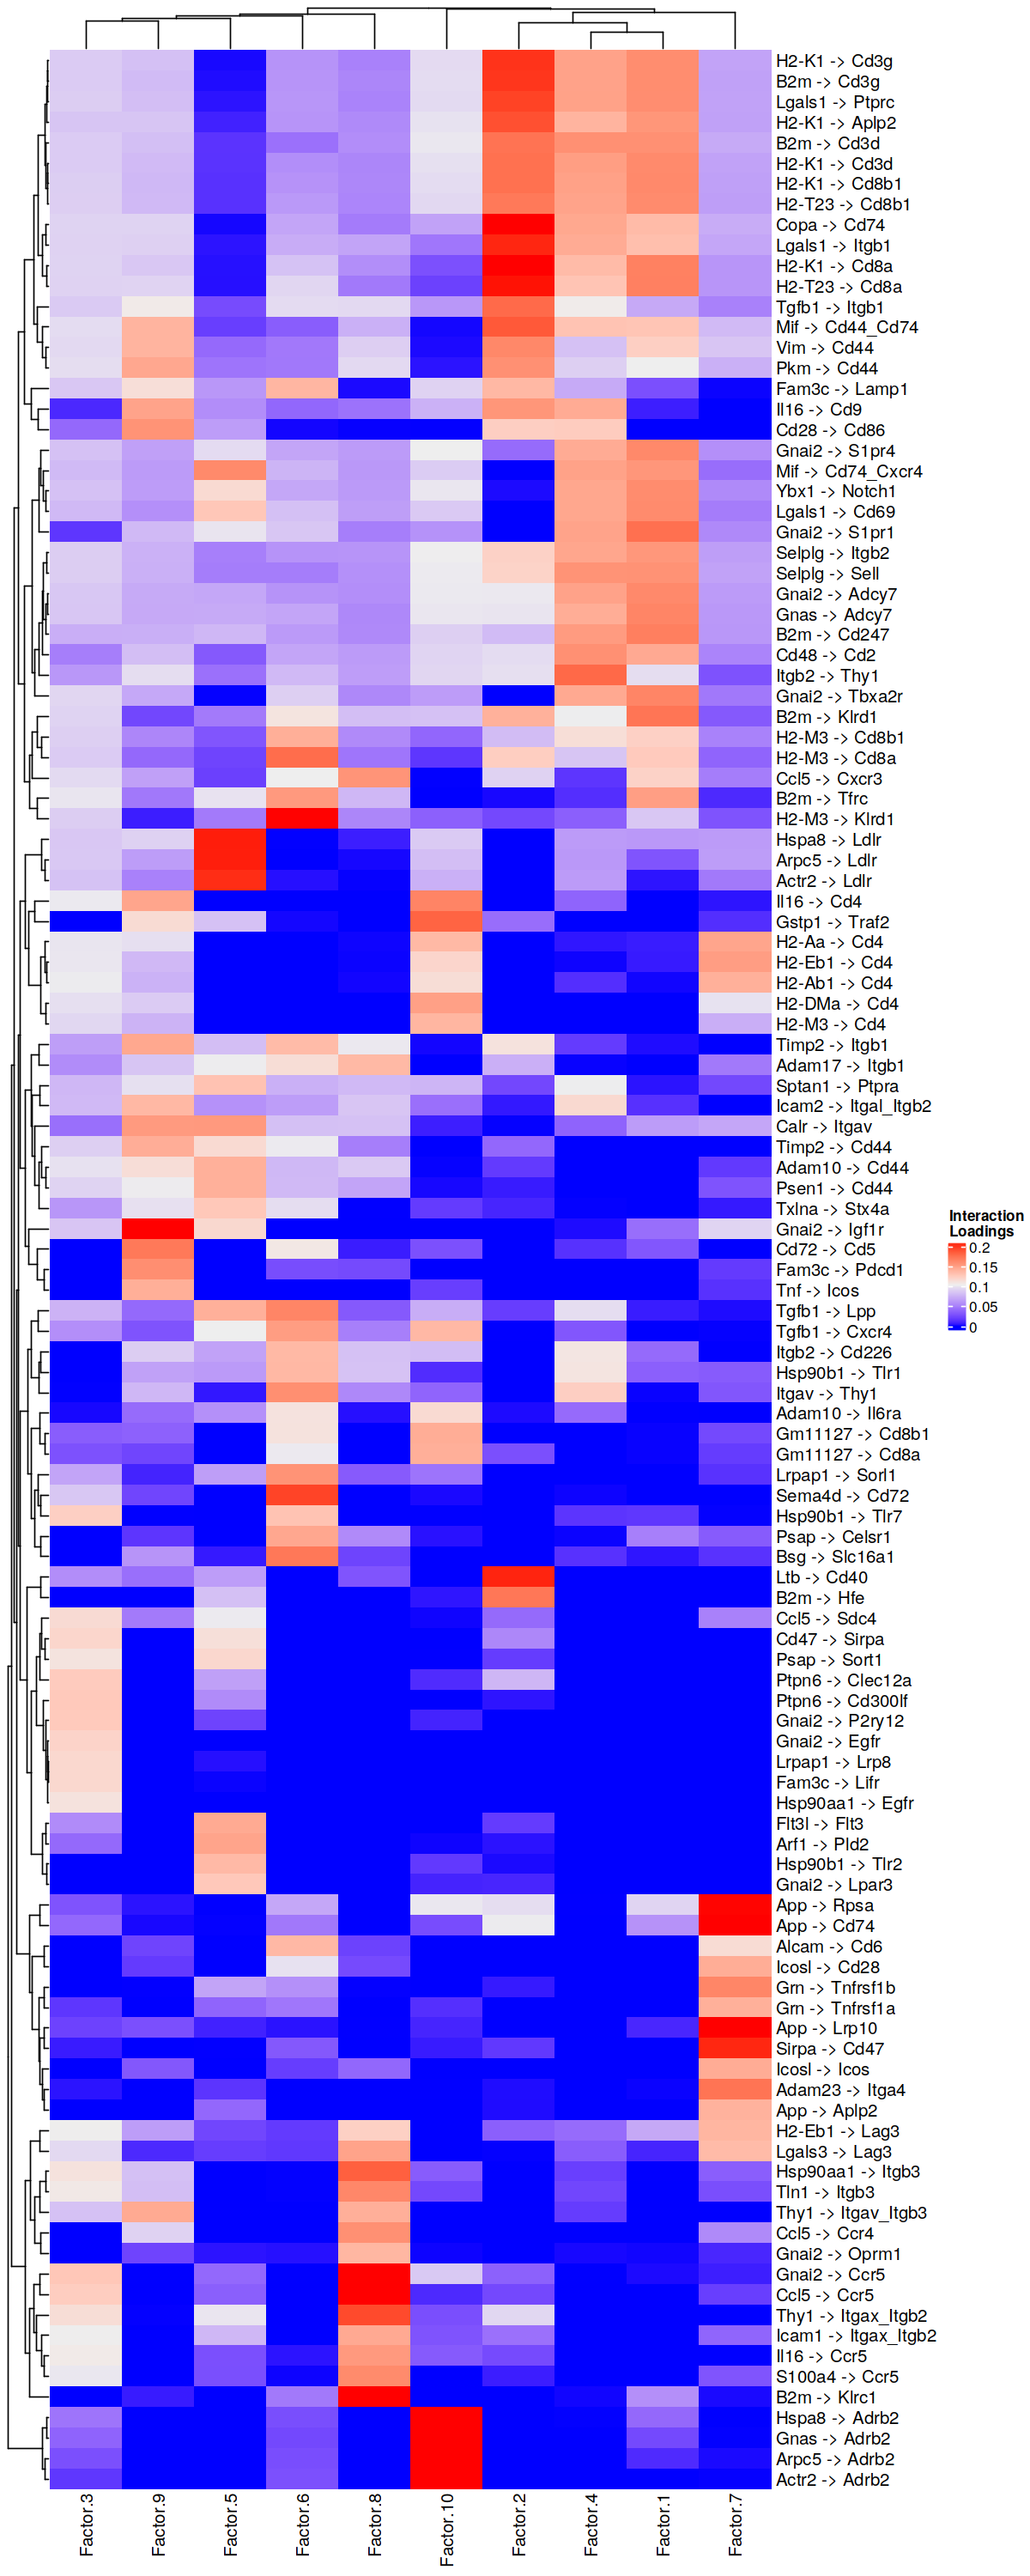

In [24]:
h_ = 25
w_ = 10
n_lrs<-15#5
options(repr.plot.height=h_, repr.plot.width=w_)
liana::plot_lr_heatmap(sce = abc.ccc.sce,  n = n_lrs)

In [25]:
top_lrs = list()
for (factor.name in paste0('Factor ', fos)){
    top_lrs[[factor.name]] = tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs))
}
top_lrs


$`Factor 2`
   H2-K1^Cd8a     Copa^Cd74   H2-T23^Cd8a      Ltb^Cd40  Lgals1^Itgb1 
    0.2091101     0.2085596     0.2057761     0.2030333     0.2026068 
   H2-K1^Cd3g      B2m^Cd3g  Lgals1^Ptprc   H2-K1^Aplp2 Mif^Cd44_Cd74 
    0.1994678     0.1986299     0.1946225     0.1896302     0.1858925 
  Tgfb1^Itgb1   H2-K1^Cd8b1    H2-K1^Cd3d      B2m^Cd3d       B2m^Hfe 
    0.1780925     0.1750681     0.1748476     0.1737134     0.1717005 

$`Factor 3`
      Gnai2^Ccr5    Ptpn6^Cd300lf     Gnai2^P2ry12    Ptpn6^Clec12a 
       0.1270348        0.1256331        0.1253241        0.1245121 
       Ccl5^Ccr5     Hsp90b1^Tlr7       Gnai2^Egfr       Cd47^Sirpa 
       0.1236660        0.1224482        0.1198297        0.1183454 
     Lrpap1^Lrp8       Fam3c^Lifr        Ccl5^Sdc4 Thy1^Itgax_Itgb2 
       0.1172095        0.1172036        0.1154328        0.1139971 
  Hsp90aa1^Itgb3    Hsp90aa1^Egfr       Psap^Sort1 
       0.1111628        0.1110122        0.1103062 

$`Factor 5`
    Hspa8^Ldlr     Arpc5^Ldlr     Actr2^Ldlr Mif^Cd74_Cxcr4     Calr^Itgav 
     0.2043070      0.2040215      0.2010029      0.1622339      0.1535194 
     Arf1^Pld2     Flt3l^Flt3     Psen1^Cd44      Tgfb1^Lpp    Adam10^Cd44 
     0.1474657      0.1441366      0.1405740      0.1405486      0.1404513 
  Hsp90b1^Tlr2   Sptan1^Ptpra    Lgals1^Cd69    Txlna^Stx4a    Gnai2^Lpar3 
     0.1352502      0.1298012      0.1271895      0.1266583      0.1263475 

$`Factor 7`
    App^Cd74    App^Lrp10     App^Rpsa   Sirpa^Cd47 Adam23^Itga4 Grn^Tnfrsf1b 
   0.2271603    0.2161012    0.2069521    0.2023783    0.1733456    0.1639797 
  H2-Eb1^Cd4    H2-Aa^Cd4   Icosl^Icos   Icosl^Cd28   H2-Ab1^Cd4 Grn^Tnfrsf1a 
   0.1513333    0.1471747    0.1427694    0.1426205    0.1407922    0.1405370 
   App^Aplp2  H2-Eb1^Lag3  Lgals3^Lag3 
   0.1393256    0.1372355    0.1341335

For each factor of interest, let's look at how the senders are interacting with teh receivers in more detail:

In [26]:
cc_plots<-list()
for (selected_factor in paste0('Factor.', fos)){
    cc_plots[[selected_factor]]<-liana::plot_c2c_cells(sce = abc.ccc.sce,
                                   factor_of_int = selected_factor,
                                    name = paste0(selected_factor, '\n', 
                                                 "Loadings Product"))    
}

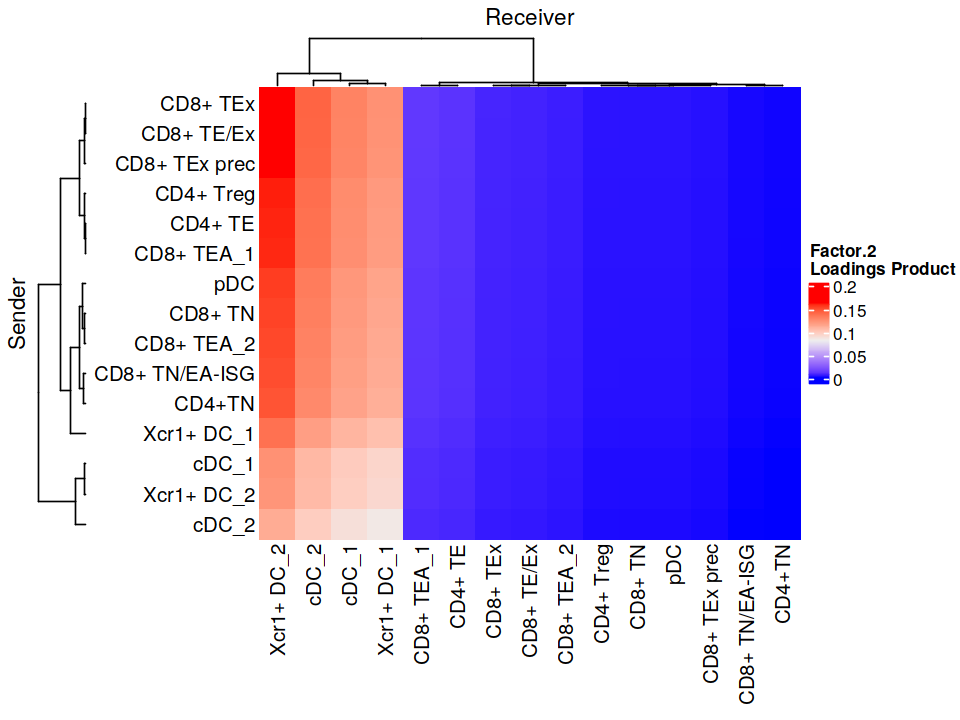

In [27]:
h_ = 6
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)
i<-1
cc_plots[[i]]
i<-i+1

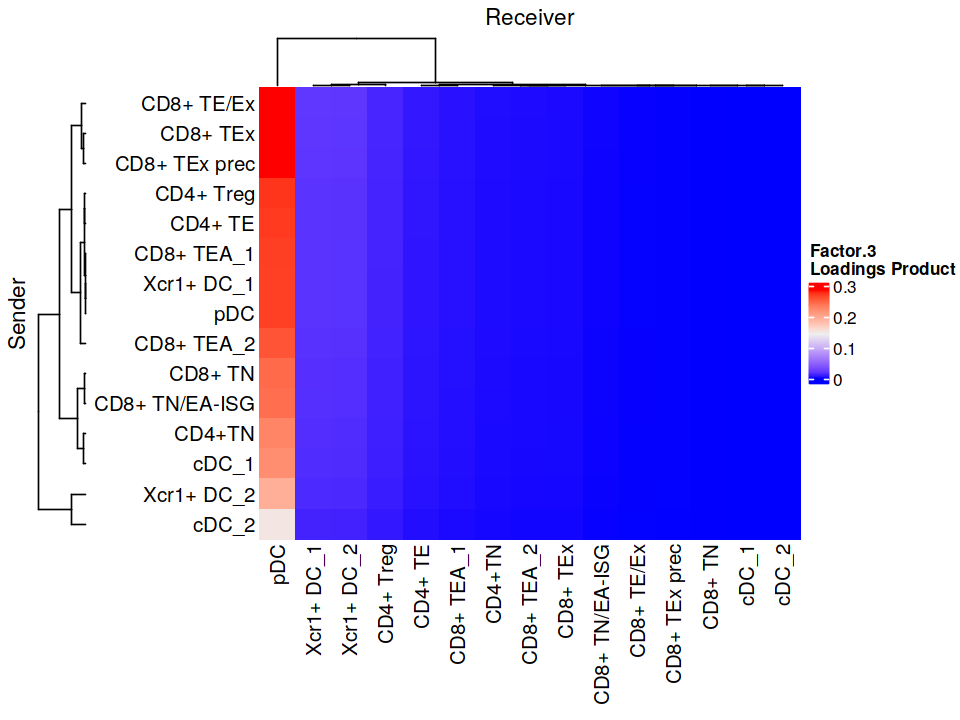

In [28]:
cc_plots[[i]]
i<-i+1

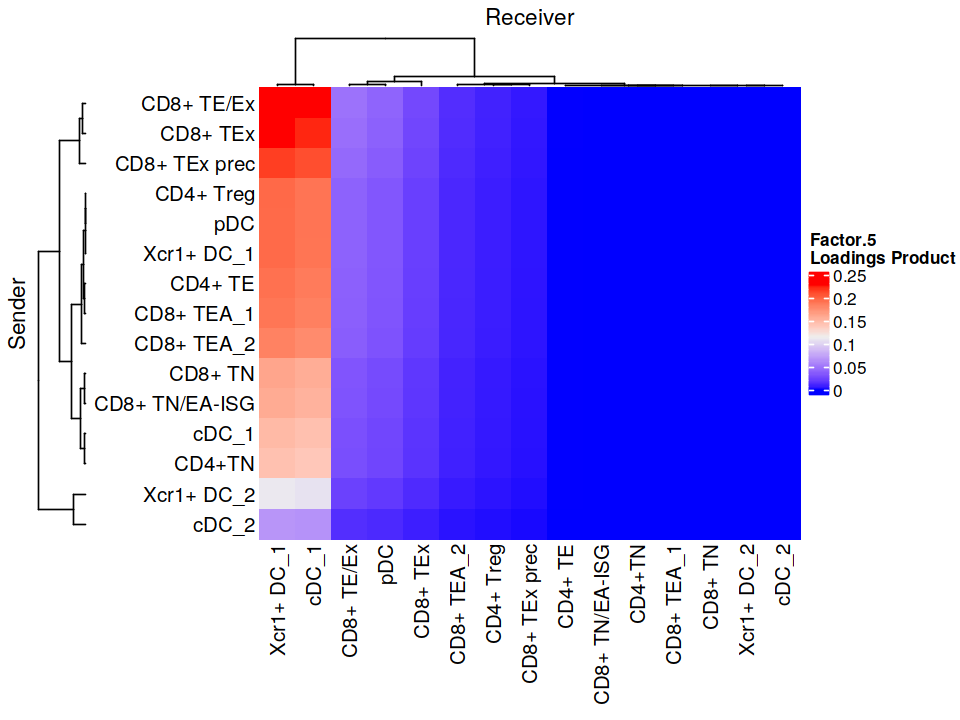

In [29]:
cc_plots[[i]]
i<-i+1

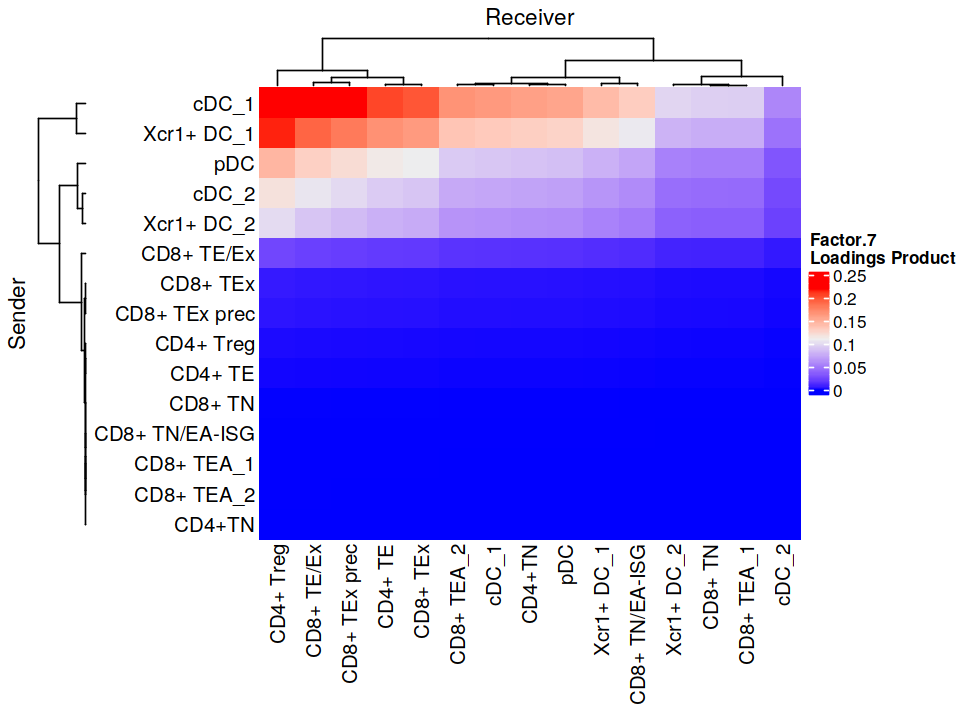

In [30]:
cc_plots[[i]]
i<-i+1

In [31]:
cc_plots[[i]]
i<-i+1

ERROR: Error in cc_plots[[i]]: subscript out of bounds


In [ ]:
cc_plots[[i]]
i<-i+1

In [ ]:
cc_plots[[i]]
i<-i+1

Since the receivers are pretty homozygous, this doesn't give us too much more information than the Factor Plots themselves.

Let's take a look at the relationship between cell-cell and ligand receptor interactions:

In [16]:
get_joint_loadings<-function(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers'){
    
    v1<-tensor$factors[[dim1]][[selected_factor]]
    names(v1)<-rownames(tensor$factors[[dim1]])

    v2<-tensor$factors[[dim2]][[selected_factor]]
    names(v2)<-rownames(tensor$factors[[dim2]])
    
    return(outer(v1, v2, "*"))
}

get_lr_by_cell_pairs<-function(tensor, selected_factor, n_cci = NULL, n_lrs = NULL){
    sr<-get_joint_loadings(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers')
    
    # flatten
    sr<-as.vector(sr)
    element.names<-expand.grid(rownames(tensor$factors$senders), rownames(tensor$factors$receivers))
    element.names<-paste0(element.names[[1]], '->', element.names[[2]])
    names(sr)<-element.names
    
    if (!is.null(n_cci)){
#         sr<-sr[sr > cci_threshold]
        sr<-sort(sr, decreasing = T)[1:n_cci]
    }
    
    # get outer with lr
    v2<-tensor$factors$interactions[[selected_factor]]
    names(v2)<-rownames(tensor$factors$interactions) 
    if (!is.null(n_lrs)){
        v2<-sort(v2, decreasing = T)[1:n_lrs]
    }

    mat<-outer(sr, v2, "*")
    
    return(t(mat))
}

In [21]:
lr_cc_list<-list()
for (selected_factor in paste0('Factor ', fos)){
    mat<-get_lr_by_cell_pairs(tensor, selected_factor, n_cci = 30, n_lrs = 30)
    write.csv(mat, paste0(data_path, 'interim/', 'Factor', selected_factor, '_lr_by_cell.csv'))
    lr_cc_list[[selected_factor]]<-ComplexHeatmap::Heatmap(mat, 
                                                   name = paste0(selected_factor), 
                                                   column_title = "lr", row_title = 'cci')
}

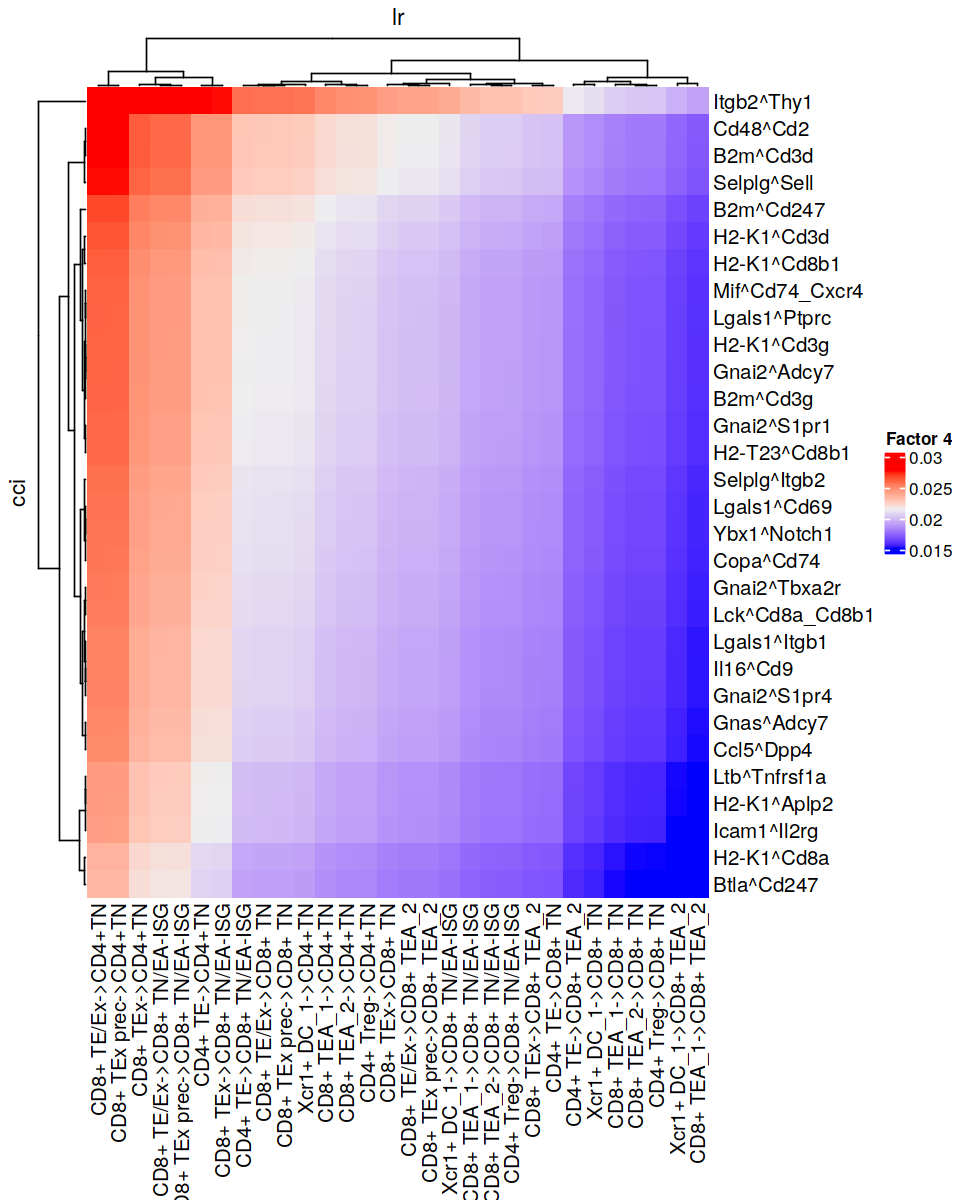

In [22]:
h_ = 10
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)

i<-1
lr_cc_list[[i]]

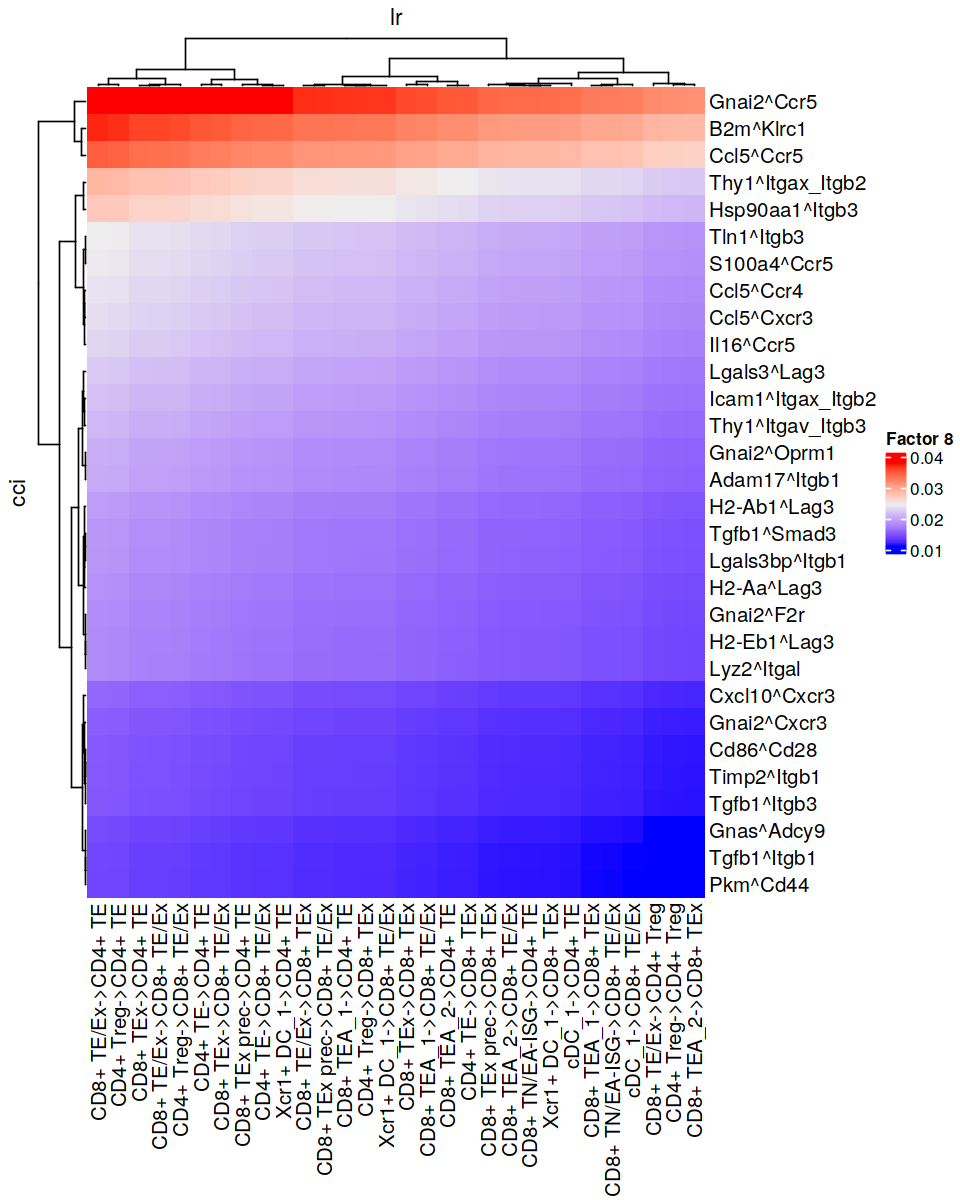

In [23]:
i<-i+1
lr_cc_list[[i]]

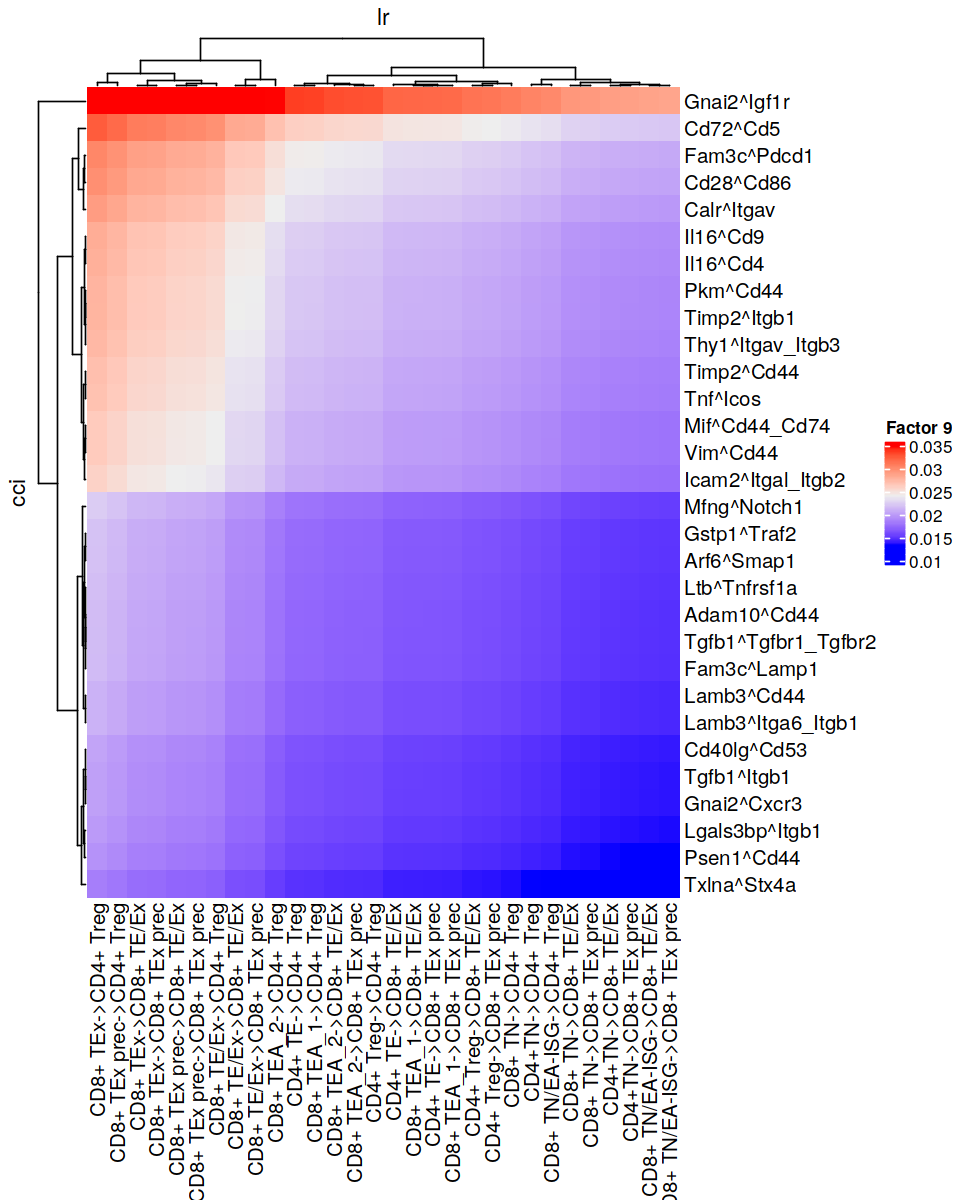

In [24]:
i<-i+1
lr_cc_list[[i]]

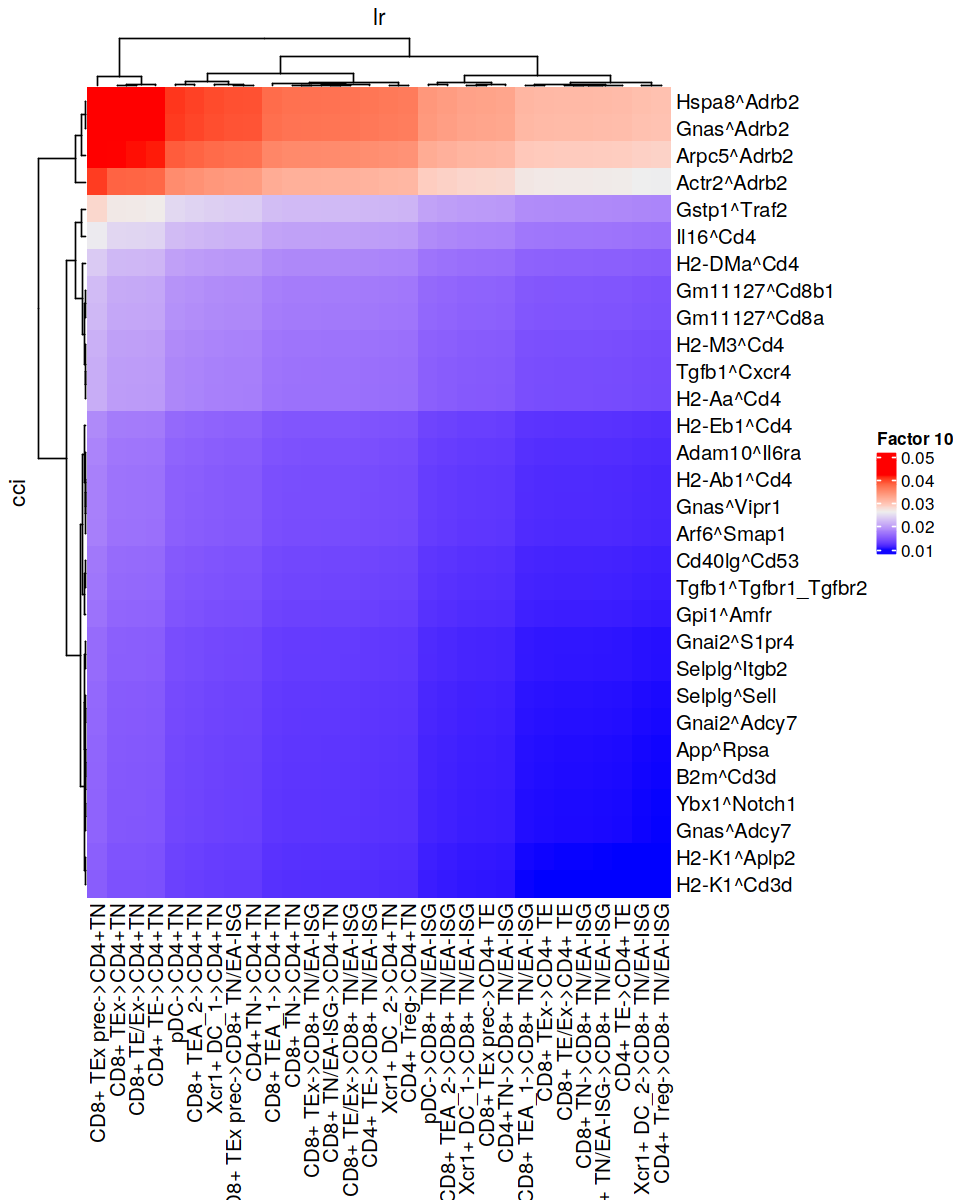

In [25]:
i<-i+1
lr_cc_list[[i]]

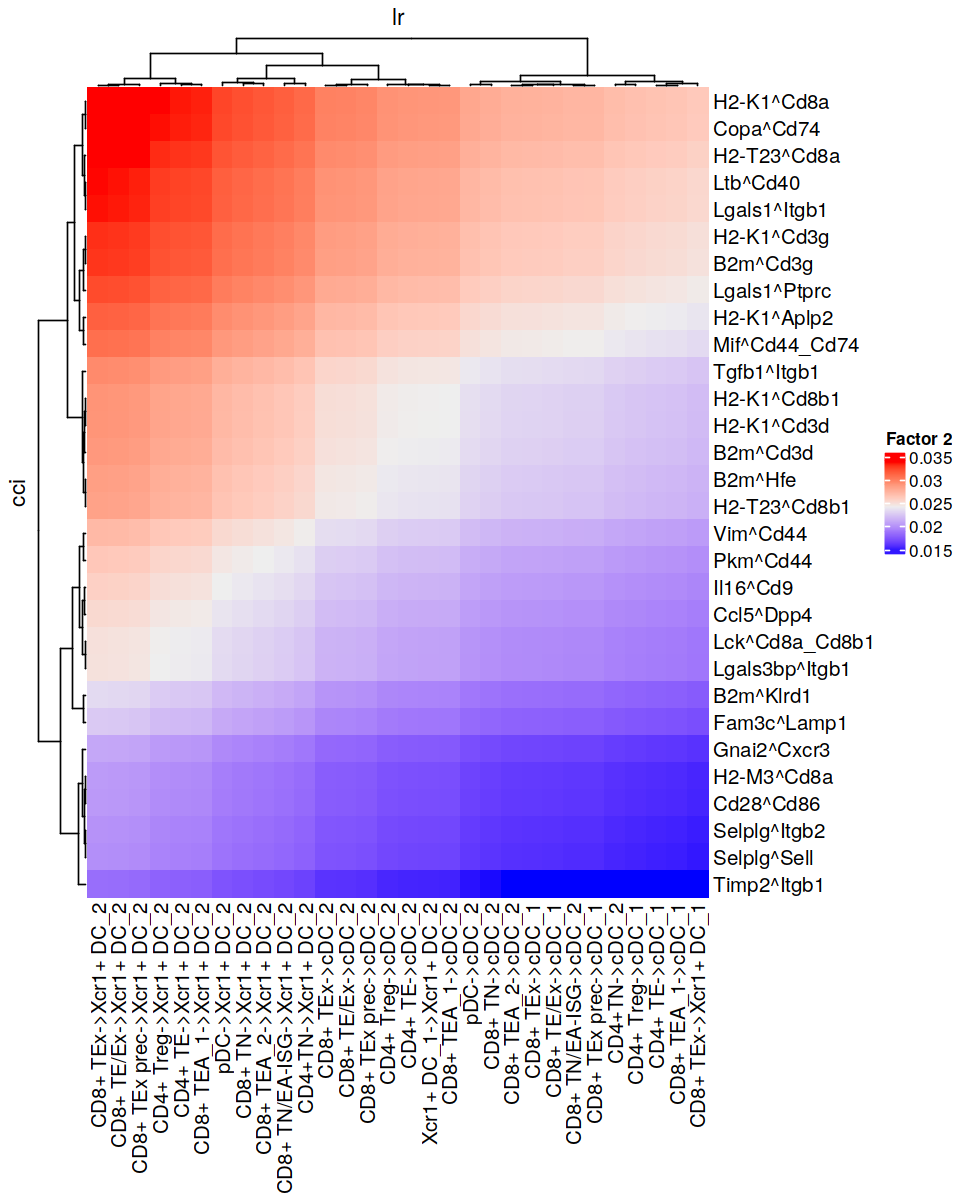

In [26]:
i<-i+1
lr_cc_list[[i]]

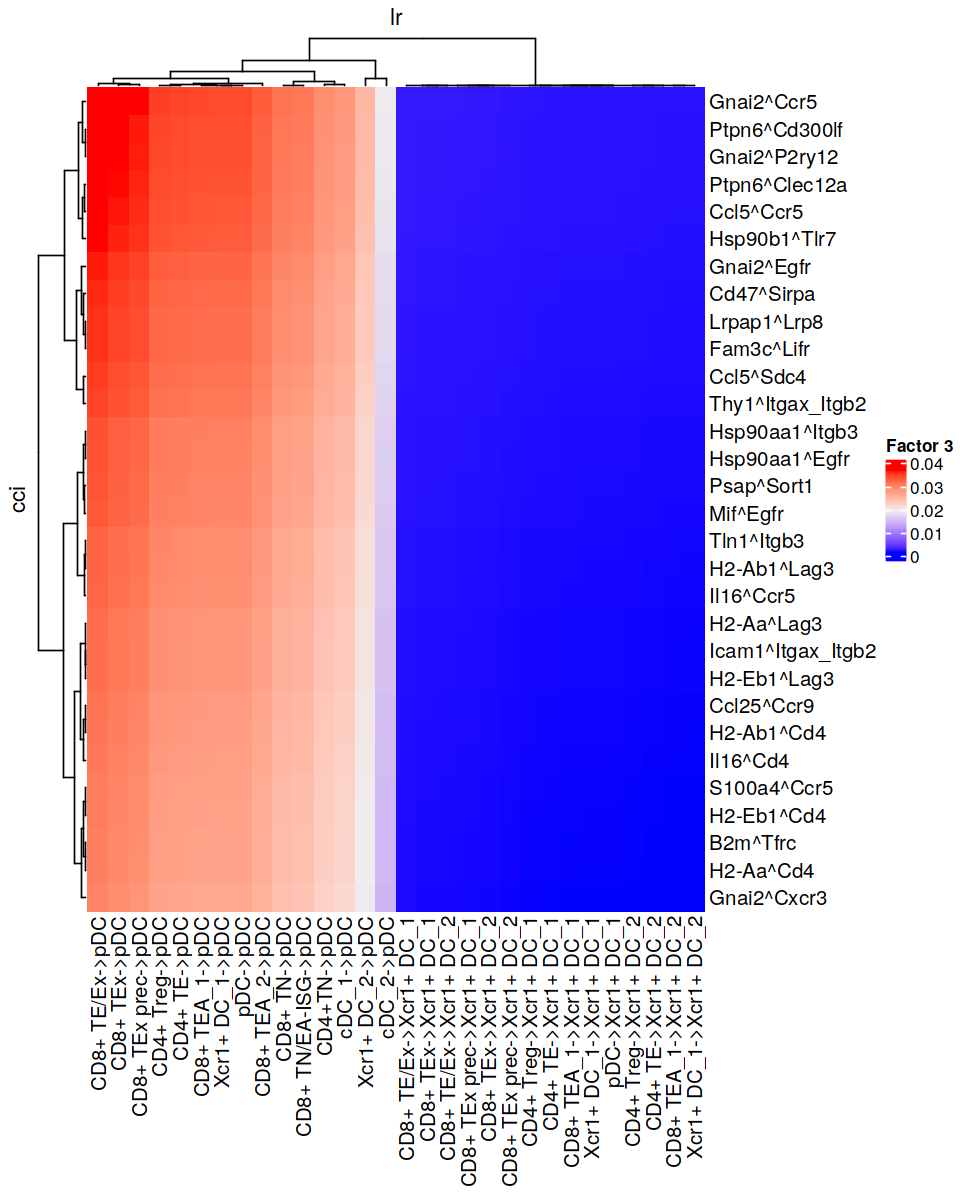

In [27]:
i<-i+1
lr_cc_list[[i]]

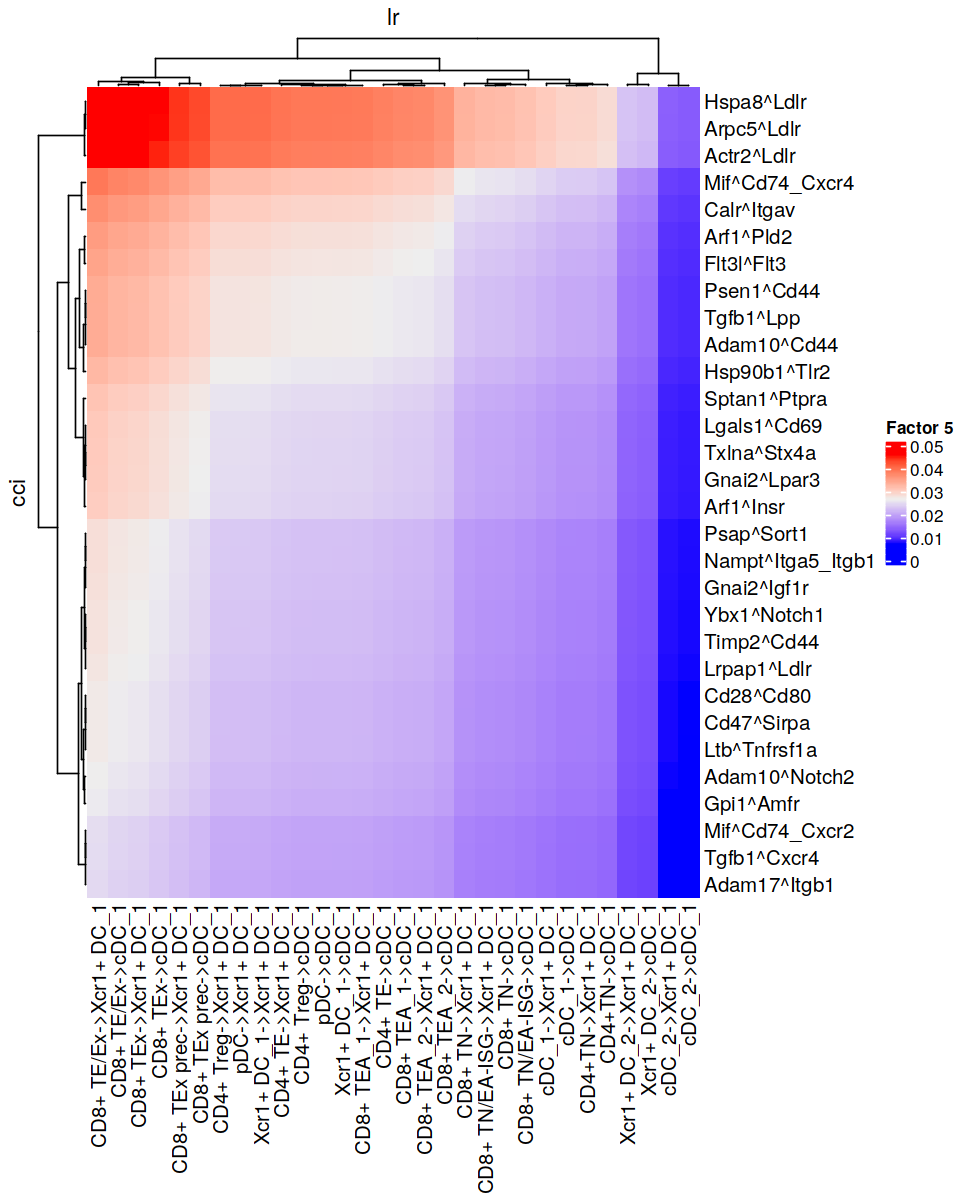

In [28]:
i<-i+1
lr_cc_list[[i]]

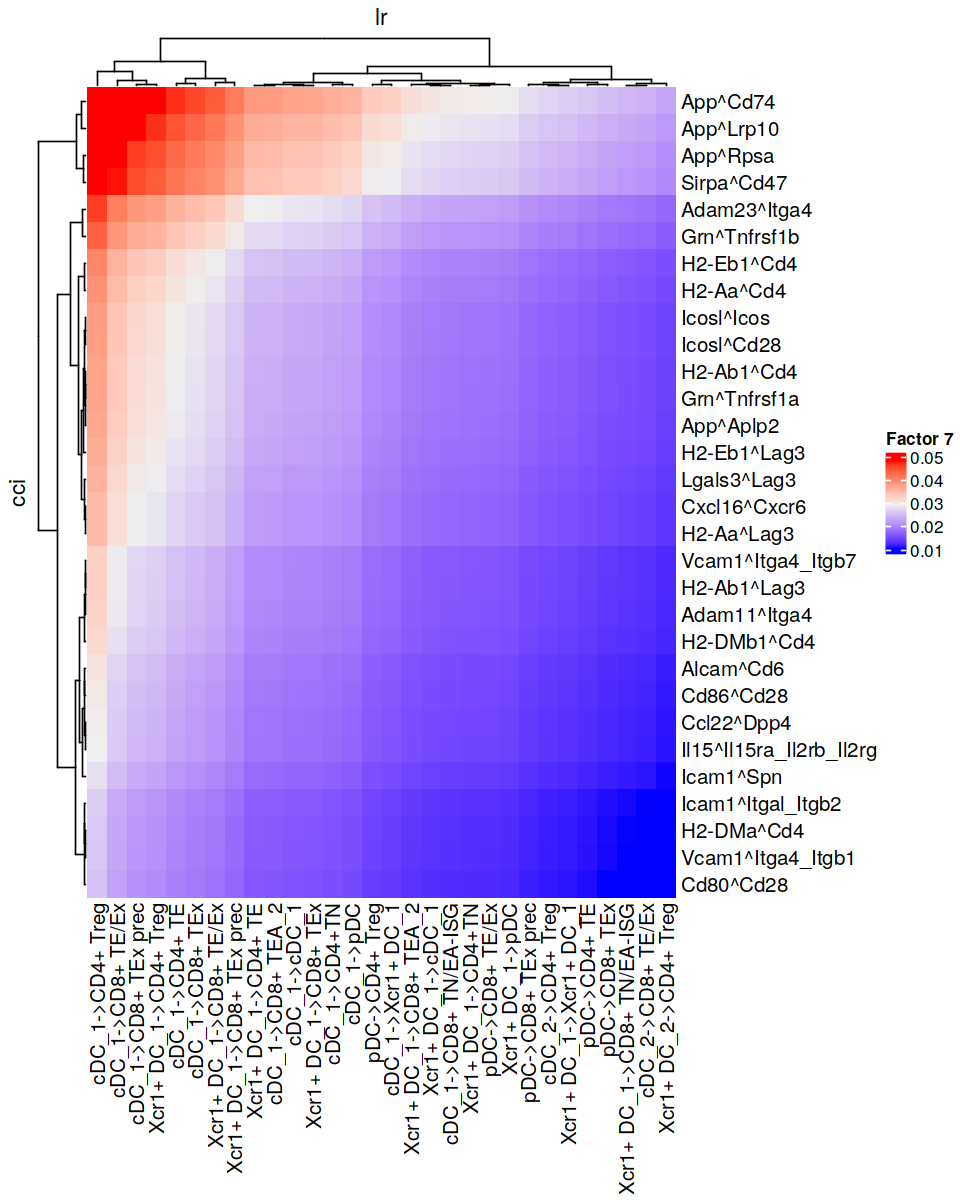

In [29]:
i<-i+1
lr_cc_list[[i]]

# Enrichment Analysis

## GSEA

Prep inputs:

In [ ]:
organism = 'mouse' 
pathwaydb = 'GOBP' # KEGG# can't use KEGG with mouse, may want to map ortholog

# lr_pairs <- liana::select_resource('Consensus')
# lr_pairs <- lr_pairs$Consensus[c('source_genesymbol', 'target_genesymbol')]
lr_pairs <- ortholog_resource[c('source_genesymbol', 'target_genesymbol')]
names(lr_pairs) <- c('ligand', 'receptor')
lr_list <- apply(lr_pairs, 1, function(x) paste0(x[[1]], '^', x[[2]]))
                 
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                        complex_sep='_', # Separation symbol of the genes in the protein complex
                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                          organism=organism,
                          pathwaydb=pathwaydb,
                          readable_name=TRUE)    
lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

GSEA:

In [ ]:
gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                               lr_set=lr_set,
                               output_folder=paste0(data_path, 'interim/')
                              )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

In [ ]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}

No significant hits...

In [ ]:
min(min(gsea_res$pvals))

In [ ]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

## ORA 

<font color='red'>**Running through metascape may introduce biases (since converting from LR --> gene list doesn't account for repeating receptors (e.g., L1-R1, L2-R1, L3-R1). It is better to convert gene pathway databases to LRs as done by c2c.external.generate_lr_geneset. Thus, will run ORA using clusterProfiler on the output of that function AND will conver the lr inputs for metascape.**</font> 


### ORA Clusterprofiler

ORA using clusterprofiler, with pathways mapped to LR pairs rather than genes as in c2c.external.generate_lr_geneset:

In [467]:
# p.adjust = BH corrected -- # https://github.com/YuLab-SMU/clusterProfiler/issues/124
# GeneRatio -- ratio of input genes in specific pathway vs input genes in all pathways https://www.biostars.org/p/220465/

# can improve visualization by directly manipulating the @result of each output
# if doing this, change qvalueCutoff to 1 and directly filter

visualize_ora<-function(cp.out, factor.name, sig.thresh = 0.1, top_n_terms = 10){
    viz.df<-cp.out@result
    viz.df[['significant']]<-paste0('fdr > ', sig.thresh)
    viz.df[viz.df$p.adjust <= sig.thresh, 'significant']<-paste0('fdr', ' \u2264 ',  sig.thresh)

    viz.df[['significant']]<-factor(viz.df[['significant']], 
                                    levels = c(paste0('fdr', ' \u2264 ',  sig.thresh), paste0('fdr > ', sig.thresh)))
    viz.df[['log.fdr']]<- -log10(viz.df$p.adjust)
    viz.df[['GeneRatio2']]<-unlist(unname(sapply(viz.df$GeneRatio, function(x) eval(parse(text=x)))))

    viz.df<-viz.df[with(viz.df, order(significant, -GeneRatio2, -log.fdr, -Count)), ]

    viz.df<-viz.df[1:top_n_terms, ]
    viz.df[['ID']]<-factor(viz.df[['ID']], 
                                    levels = rev(viz.df[['ID']]))

    green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
    yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
    red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

    lower_q = min(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    upper_q = max(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    middle_q = mean(c(lower_q, upper_q))#median(viz.df$log.fdr[!(is.na(viz.df$log.fdr))]) 
    # middle_q = 7.5

    g<-ggplot(data = viz.df, aes(x = GeneRatio2, y = ID, color = log.fdr, size = Count, shape = significant)) + 
    geom_point() + 
    ylab('') + xlab('GeneRatio') + ggtitle(factor.name) +
    scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(fdr)', 
                         limits = c(lower_q, upper_q), midpoint = middle_q) + 
    scale_shape_manual(values = c(16,4), drop = FALSE)+
    scale_size_continuous(range = c(4,12))+
    theme_bw() + theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                      text = element_text(size = 15), plot.title = element_text(hjust = 0.5))


    return(g)
}

In [468]:
# prep input
keys<-names(lr_set)

lr_set_R<-list()
for (key in keys){
    lr_set_R[[key]]<-reticulate::iterate(reticulate::as_iterator(lr_set[key]))
} 

ora_db<-stack(lr_set_R)
ora_db<-ora_db[c(2,1)]
names(ora_db)<-c('Pathway', 'LR_Pair')

Run with setting background to the entire LIANA database that mapped to pathways:

In [474]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res<-list()
for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    ora_res[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

In [475]:
# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn)
    
    dotplot_list[[fn]]<-g
    

}

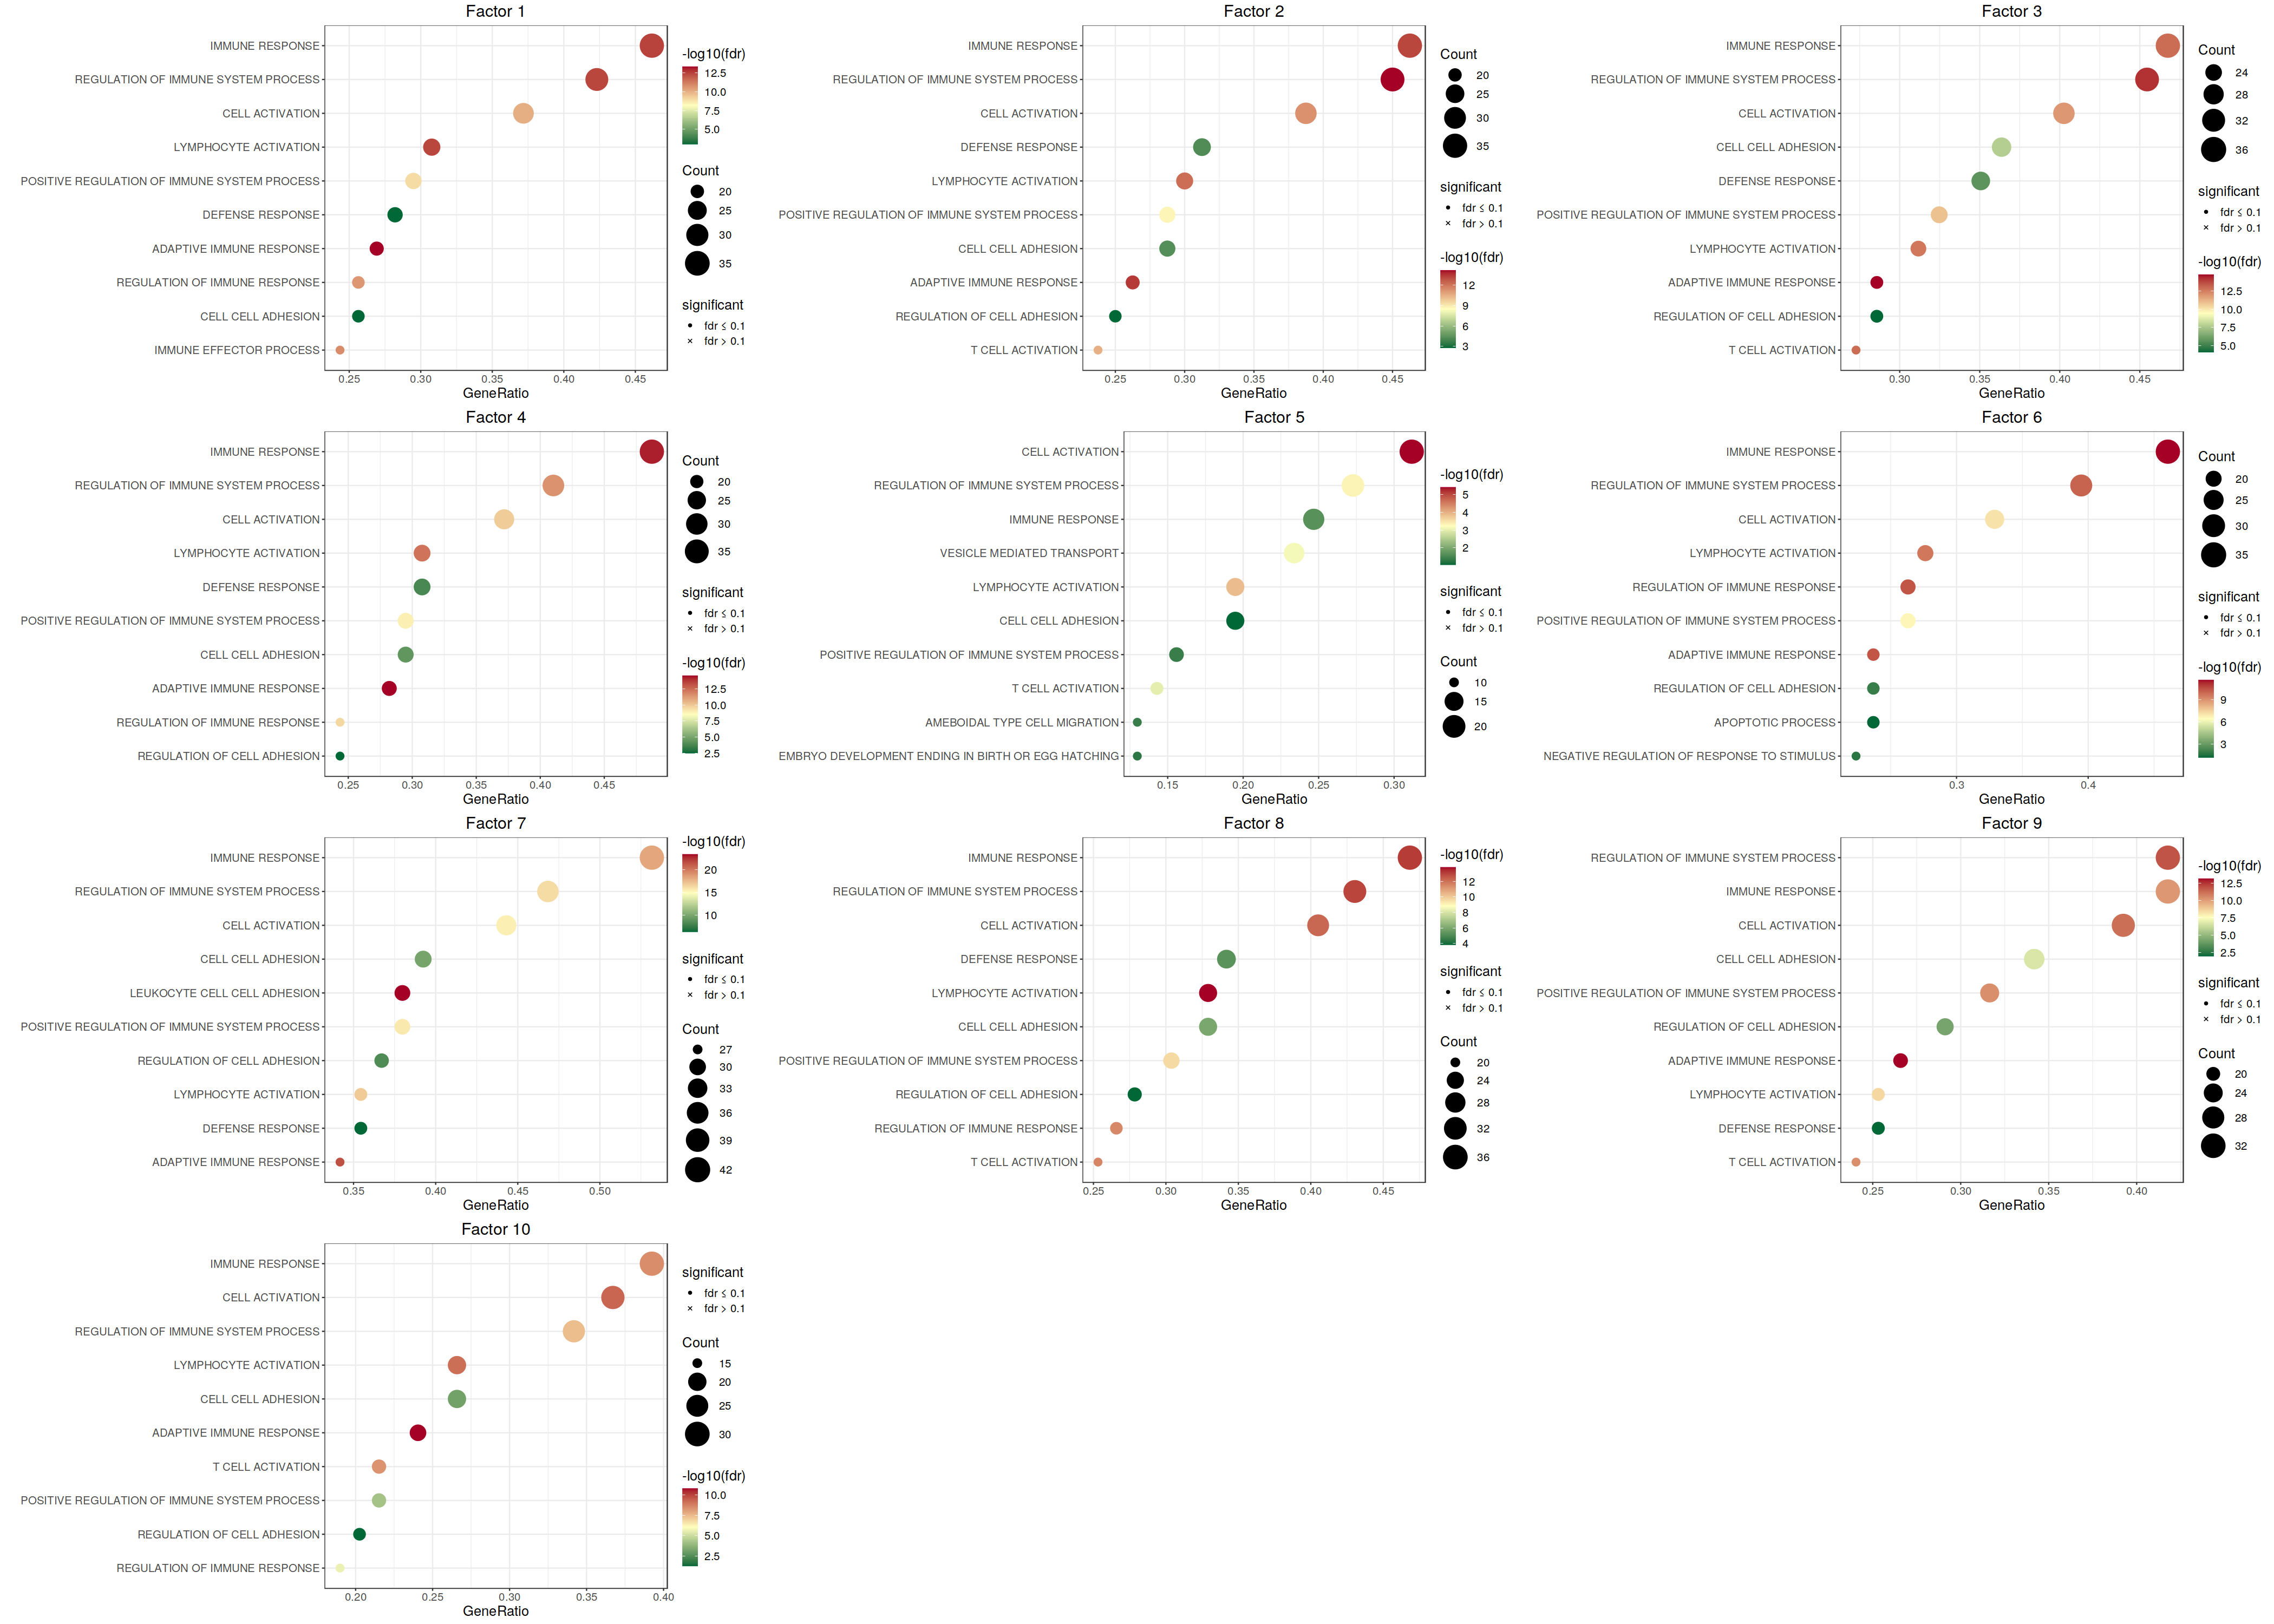

In [476]:
h_ = 25
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]], dotplot_list[[3]], dotplot_list[[4]], dotplot_list[[5]], 
                   dotplot_list[[6]], dotplot_list[[7]], dotplot_list[[8]], dotplot_list[[9]], dotplot_list[[10]],
                   ncol = 3)
})

g

Run with setting background only to final scored interctions:

In [477]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res_strict<-list()
for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    
    # for now, set background to all SCORED lrs, which is a subset of ora_db
    ora_res_strict[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                      universe = rownames(tensor$factors$interactions), 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

In [478]:
# visualize
dotplot_list_strict<-c()
for (fn in names(ora_res_strict)){
    cp.out<-ora_res_strict[[fn]]
    g<-visualize_ora(cp.out, fn)
    
    dotplot_list_strict[[fn]]<-g
    

}

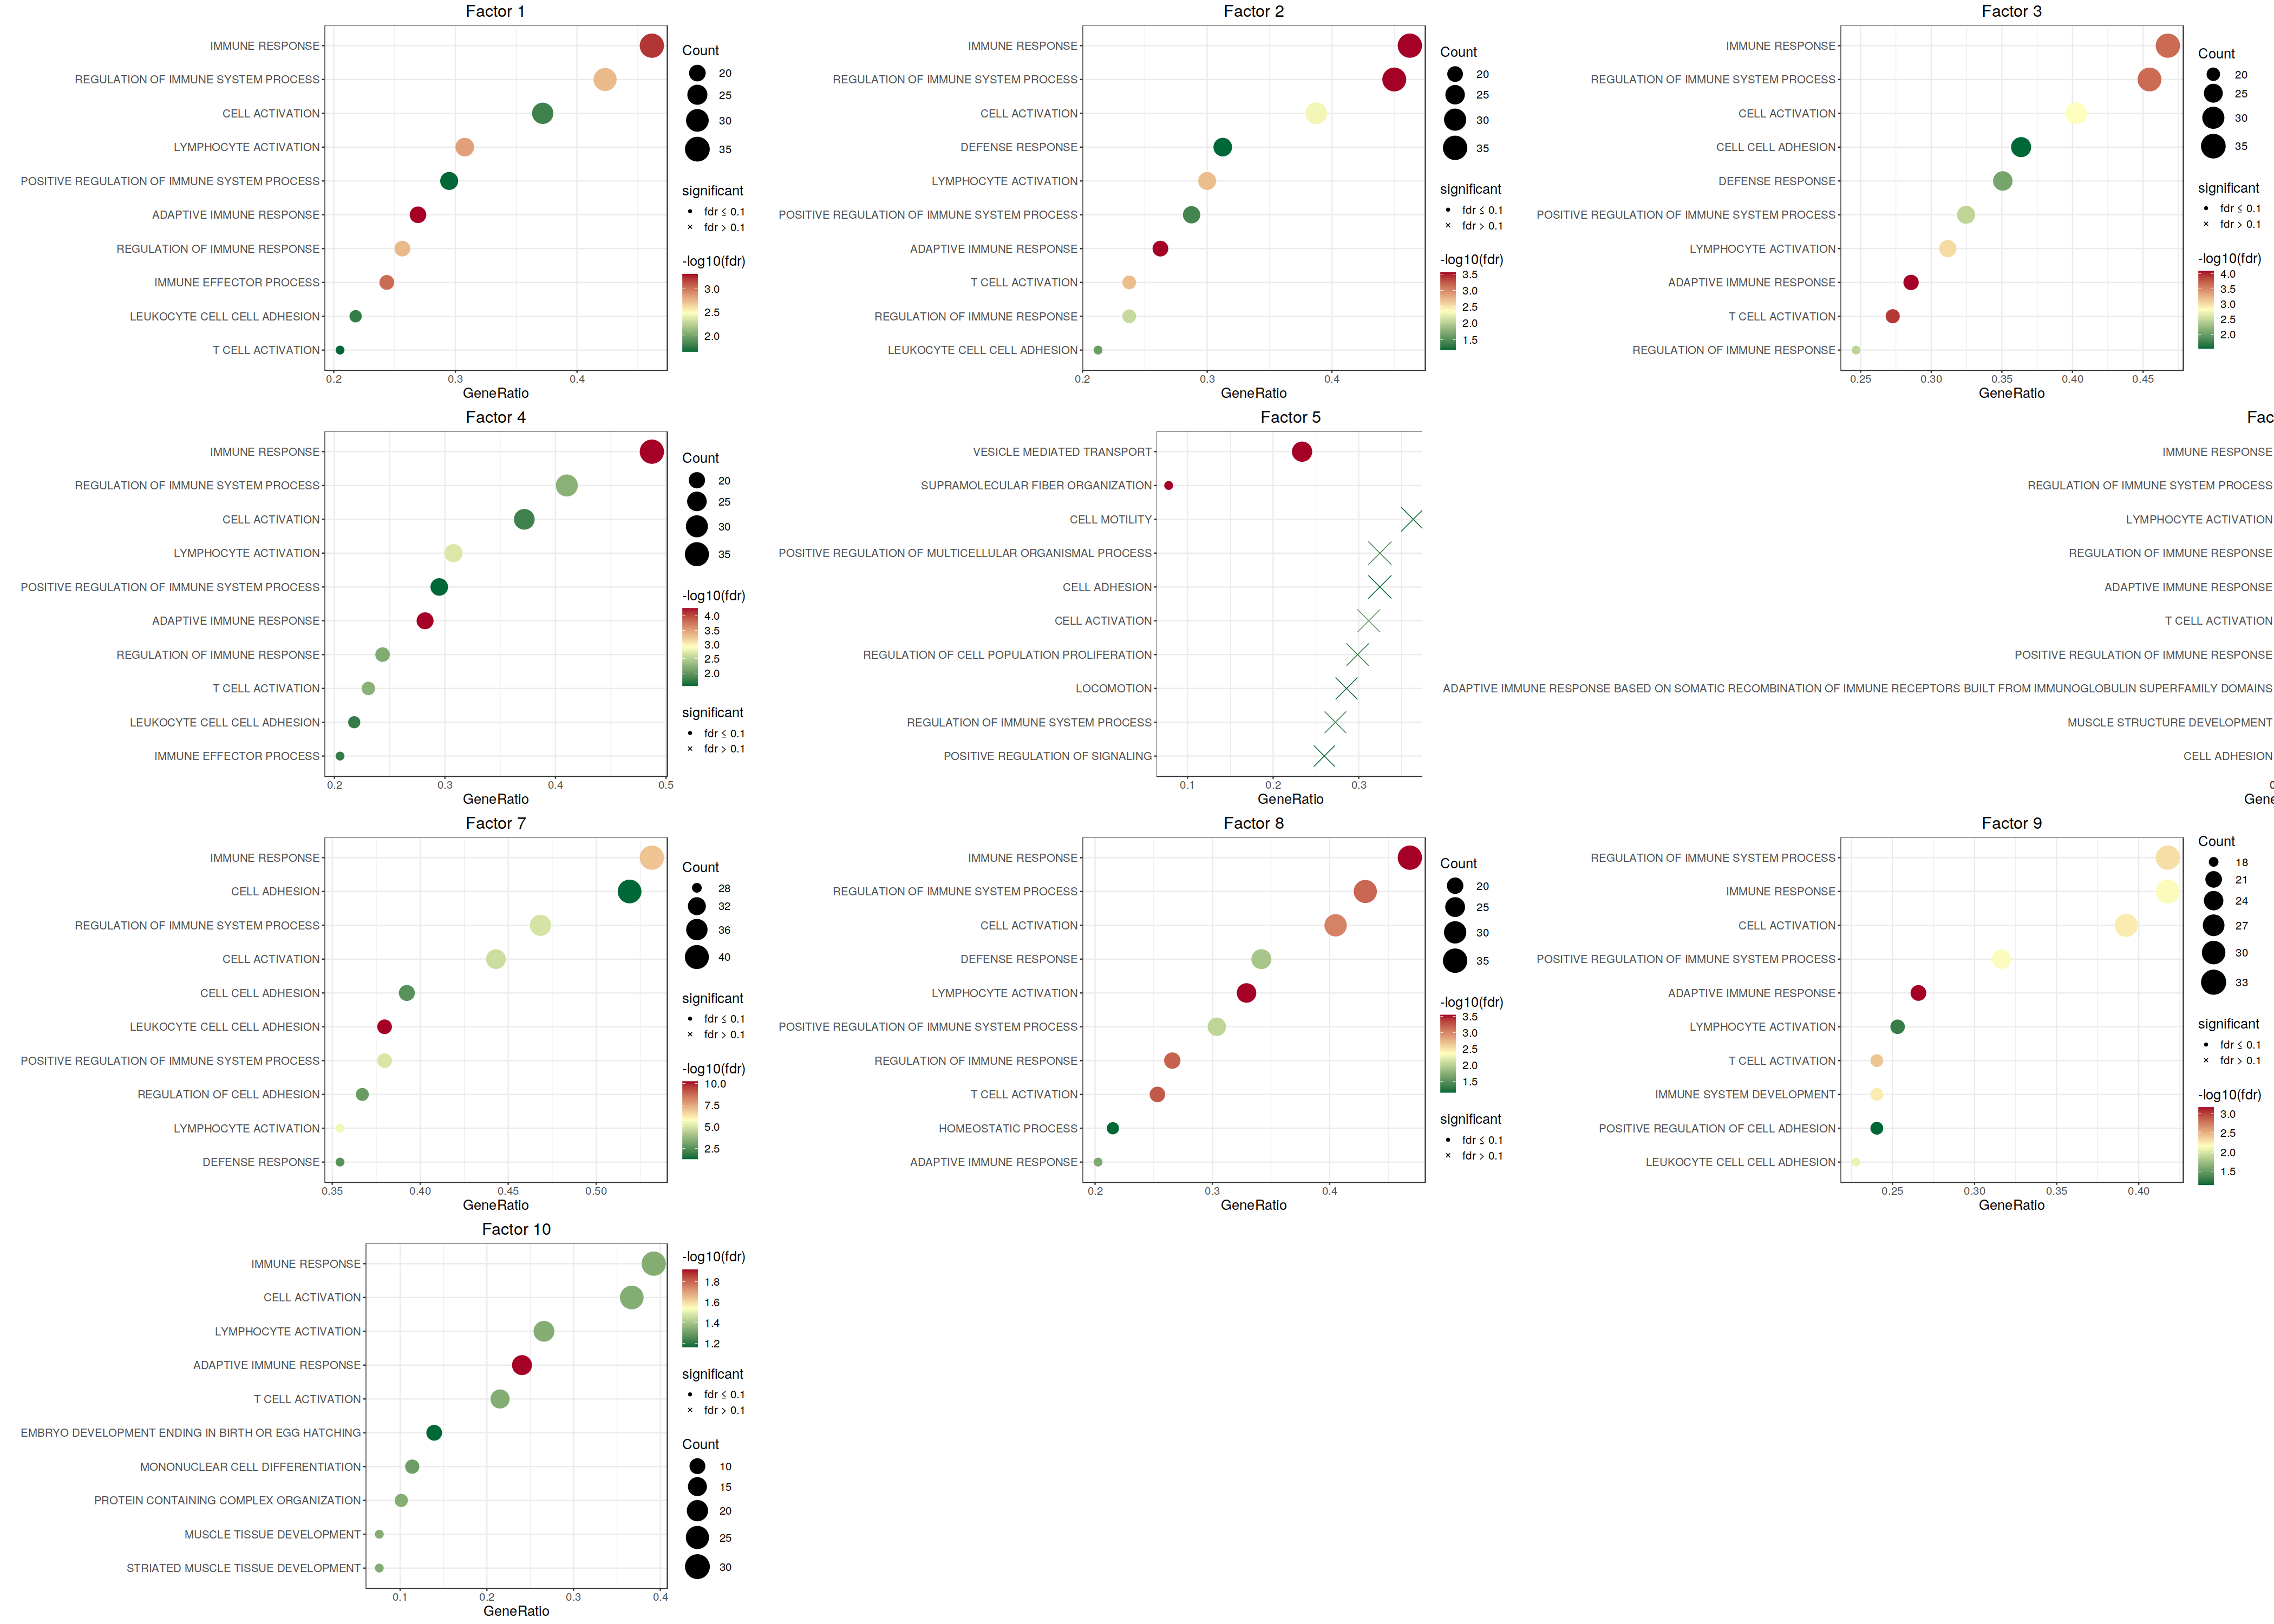

In [479]:
h_ = 25
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list_strict[[1]], dotplot_list_strict[[2]], dotplot_list_strict[[3]], dotplot_list_strict[[4]], dotplot_list_strict[[5]], 
                   dotplot_list_strict[[6]], dotplot_list_strict[[7]], dotplot_list_strict[[8]], dotplot_list_strict[[9]], dotplot_list_strict[[10]],
                   ncol = 3)
})

g

Note, neither background approach is perfect. The first includes LRs that may not even have been in the dataset, the second excludes LRs that may have been thresholded out. To get the real backgorund, would need to rerun with the least stringent thresholds. 

### ORA Metascape

Prepping inputs for metascape. Will run the top 10% of scored LRs for each factor. Will use the background as all genes in the single-cell dataset that are present in the input CCC LR DB:

In [ ]:
lr_pair_genes<-unique(c(lr_pairs$ligand, lr_pairs$receptor)) # lr_pairs is the full LR DB that liana was run on
lr_pair_genes<-unique(unlist(str_split(as.character(lr_pair_genes), '_'))) # complexes joined by _
dataset.genes<-rownames(abc.ccc@assays$RNA@data)

universe.background<-intersect(lr_pair_genes, dataset.genes) 

# get all teh scored lrs and convert LRs --> genes
scored_lrs<-unique(unlist(str_split(as.character(factors$interactions$lr), '\\^'))) # interactions joined by ^
scored_lrs<-unique(unlist(str_split(as.character(scored_lrs), '_'))) # complexes joined by _


cond1<-(length(scored_lrs) > length(lr_pair_genes))
cond2<-(length(setdiff(scored_lrs, lr_pair_genes)) > 0)
cond3<-(length(setdiff(scored_lrs, dataset.genes)) > 0)
if ((cond1) | (cond2) | (cond3)){
    stop('Unexpected difference in identified loadings and LR DB')
}

In [226]:
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

metascape_input = list()
# set background as all lr pairs from database that are present in sc dataset
metascape_input[['_BACKGROUND']]<-universe.background

for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    # LRs --> genes
    factor_genes<-unique(unlist(str_split(as.character(factor_lrs), '\\^'))) # LR interactions joined by ^
    factor_genes<-unique(unlist(str_split(as.character(factor_genes), '_'))) # complexes joined by _
    metascape_input[[factor.name]]<-factor_genes
}

# format input to metascape
max.length <- max(sapply(metascape_input, length))
metascape_input <- lapply(metascape_input, function(v) { c(v, rep(NA, max.length-length(v)))})
metascape_input<-do.call(cbind, metascape_input)
write.csv(metascape_input, paste0(data_path, 'interim/', 'lr_metascape_input.csv'), row.names=FALSE)

Let's visualize the output:

In [504]:
format.ms<-function(ms, val_col){
    val_df<-as.data.frame(pivot_wider(data = ms, id_cols = 'GeneList', names_from = 'Description', 
                                      values_from = val_col, 
                                    values_fn = mean))
    val_df<-t(column_to_rownames(x = val_df, loc = 1))

    return(val_df)
}

In [481]:
ms.top20<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out/Enrichment_heatmap/HeatmapSelectedGO.csv'))
ms.top100<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out/Enrichment_heatmap/HeatmapSelectedGOTop100.csv'))
ms<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out/Enrichment_GO/GO_AllLists.csv'))

First, let's see if there is any duplicate Description/GeneList combinations:

In [482]:
ms %>%
  dplyr::group_by(GeneList, Description) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)

GeneList  Description             n
1 Factor 10 Notch signaling pathway 2
2 Factor 5  Notch signaling pathway 2

In [486]:
ms[(ms$Description == 'Notch signaling pathway') & (ms$GeneList %in% c('Factor 10', 'Factor 5')), ]

Category                CategoryID GO         Description            
388  WikiPathways            27         WP29       Notch signaling pathway
404  GO Biological Processes 19         GO:0007219 Notch signaling pathway
1714 GO Biological Processes 19         GO:0007219 Notch signaling pathway
1716 WikiPathways            27         WP29       Notch signaling pathway
     PARENT_GO                          LogP Enrichment Z.score
388                                     -3.3 5.1        4.7    
404  19_GO:0050896 response to stimulus -3.2 3.8        4.3    
1714 19_GO:0050896 response to stimulus -2.1 2.9        3.1    
1716                                    -2.1 3.7        3.3    
     X.TotalGeneInLibrary X.GeneInGO X.GeneInHitList X.GeneInGOAndHitList
388  1200                 14         101             6                   
404  1200                 25         101             8                   
1714 1200                 25         116             7                   
1716 1200                 14         116             5                   
     X.InGO STDV..InGO GeneID                                         
388  5.9    2.4        11491|17305|18128|18129|19164|21926            
404  7.9    2.7        11487|11491|11820|18128|18129|19164|21803|21813
1714 6.0    2.2        11487|11491|18128|18129|19164|21803|21813      
1716 4.3    1.9        11491|17305|18128|18129|19164                  
     Hits                                               Log.q.value. GeneList 
388  Adam17|Mfng|Notch1|Notch2|Psen1|Tnf                -2.0         Factor 10
404  Adam10|Adam17|App|Notch1|Notch2|Psen1|Tgfb1|Tgfbr2 -2.0         Factor 10
1714 Adam10|Adam17|Notch1|Notch2|Psen1|Tgfb1|Tgfbr2     -1.3         Factor 5 
1716 Adam17|Mfng|Notch1|Notch2|Psen1                    -1.3         Factor 5

In [487]:
'Notch signaling pathway' %in% ms.top100$Description

[1] FALSE

Looks like there is one term that is repeated twice, Notch signaling pathway. However, this term is not in our top enriched terms, so it won't effect things. Furthermore, output values are quite similar. So, we aggregate by the average in this case. 

In [528]:
freq<-format.ms(ms = ms, val_col = 'X.InGO')[ms.top20$Description, paste0('Factor ', 1:tensor$rank)]
pvals<-format.ms(ms = ms, val_col = 'Log.q.value.')[ms.top20$Description, paste0('Factor ', 1:tensor$rank)]

pvals<-as.data.frame(pvals)
pvals[['Enrichment.Term']]<-rownames(pvals)
freq<-as.data.frame(freq)
freq[['Enrichment.Term']]<-rownames(freq)

pvals<-melt(pvals, id.vars = 'Enrichment.Term', value.name = 'log10p', variable.name = 'Condition')
freq<-melt(freq, id.vars = 'Enrichment.Term', value.name = 'Frequency', variable.name = 'Condition')
pvals[['log10p']] <- -as.numeric(pvals[['log10p']]) 

viz.df <- cbind(pvals, Frequency = as.numeric(freq$Frequency))

Warning message:
“Removed 25 rows containing missing values (`geom_point()`).”


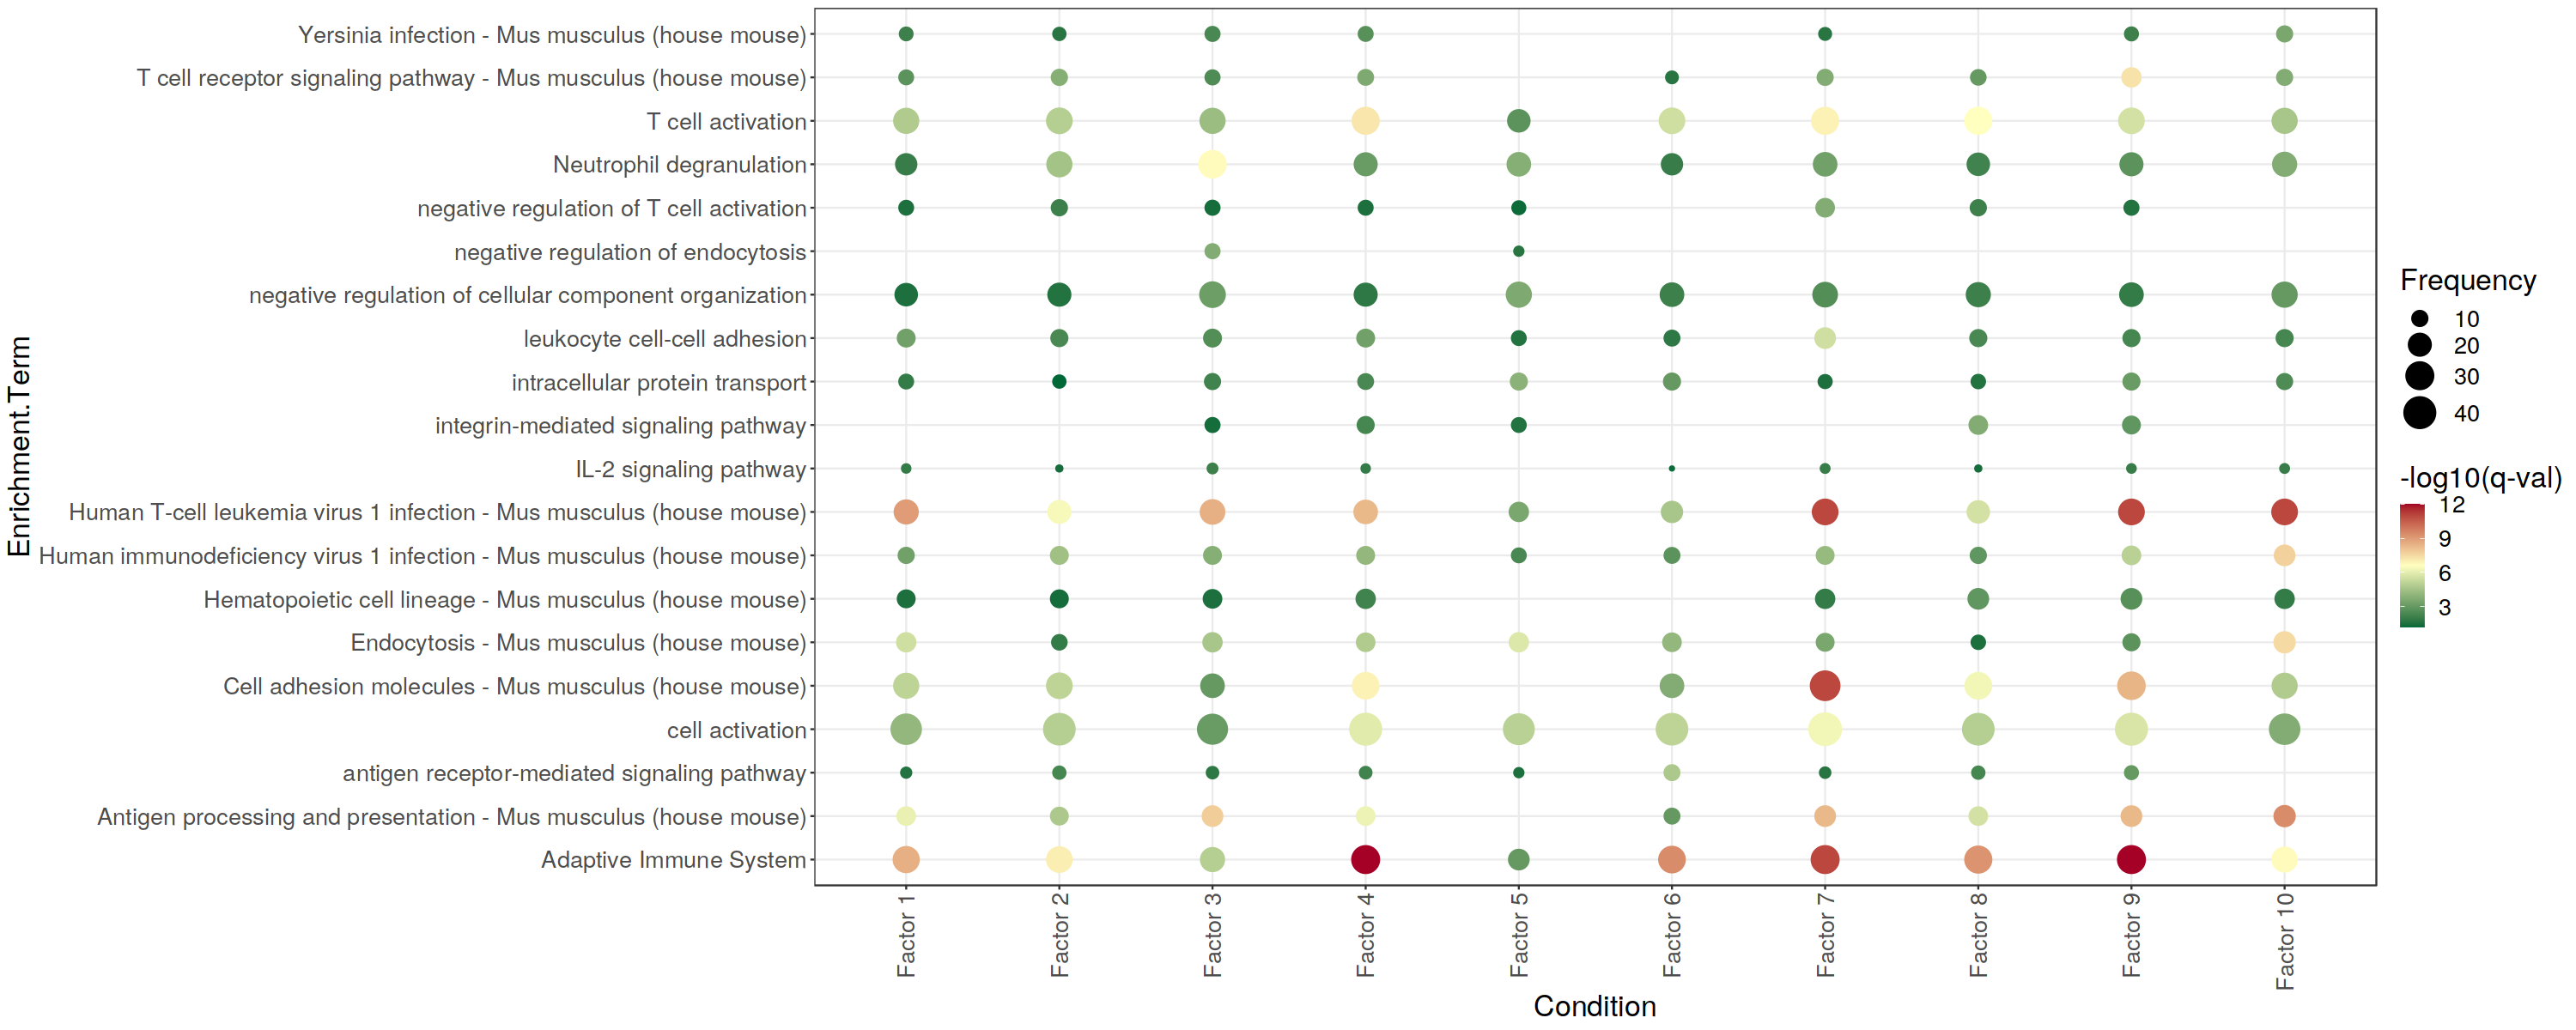

In [539]:
h_ = 10
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

lower_q = min(viz.df$log10p[!(is.na(viz.df$log10p))])
upper_q = max(viz.df$log10p[!(is.na(viz.df$log10p))])
middle_q = mean(c(lower_q, upper_q)) # median(viz.df$log10p[!(is.na(viz.df$log10p))]) # 
# middle_q = 7.5

g<-ggplot(data = viz.df, aes(x = Condition, y = Enrichment.Term, color = log10p, size = Frequency)) + 
geom_point() + 
scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(q-val)', 
                     limits = c(lower_q, upper_q), midpoint = middle_q) + 
scale_size_continuous(range = c(1,10)) +
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                  text = element_text(size = 20))


# for (ext in c('.svg', '.png', '.pdf')){
#     fn<-paste0(data_path, 'figures/', 'lr_metascape_enrichment_dotplot', ext)
#     ggsave(fn, g, height = h_, width = w_)}

g

## Progeny Enrichment

In [536]:
# obtain progeny gene sets
progeny <- decoupleR::get_progeny(organism = 'mouse', top=5000) %>%
    select(-p_value)

# convert to LR sets
progeny_lr <- generate_lr_geneset(sce = abc.ccc.sce,
                                  resource = progeny)

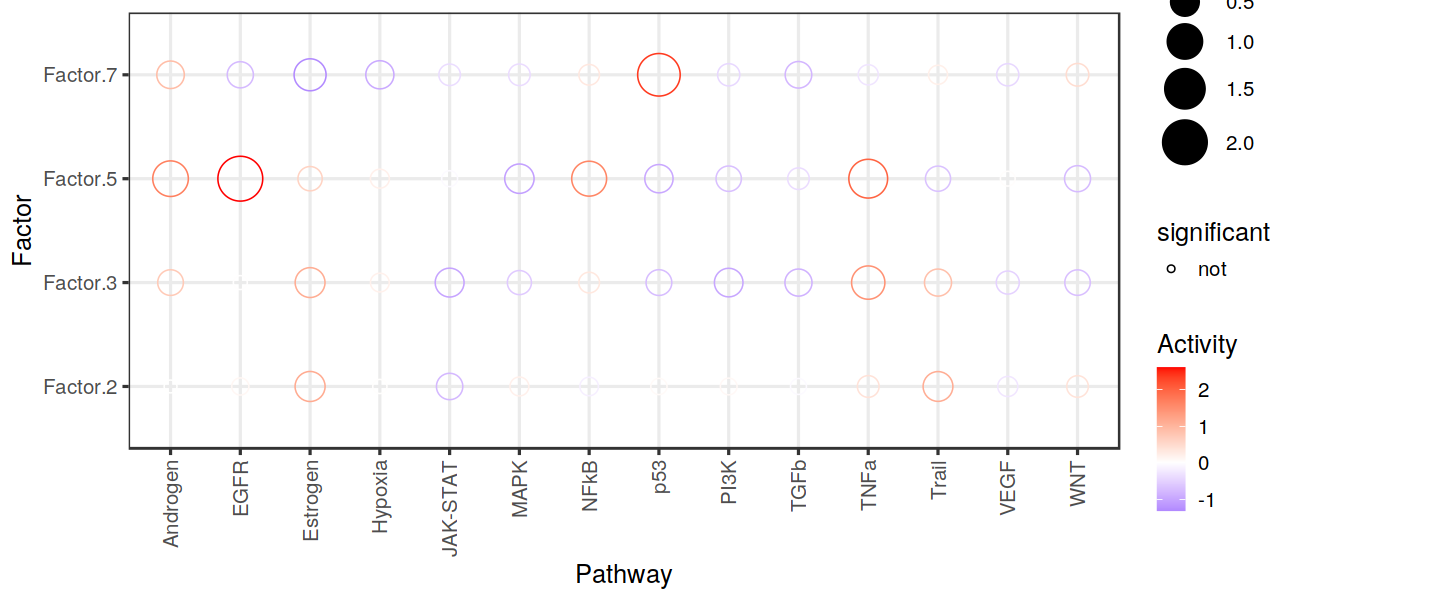

In [537]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

# interaction loadings to matrix
mat <- factors$interactions[, c('lr', paste0('Factor.', fos))] %>%
    column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.1, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

In [ ]:
# progeny_lr[(progeny_lr$set == 'Estrogen') & (progeny_lr$mor > 0), ]

In [538]:
# pathway = 'JAK-STAT'
# factor = 'Factor.8'
# # Plot LRs associated with Estrogen
# lrs <-  factors$interactions %>%
#   left_join(progeny_lr, by="lr") %>%
#   filter(set==pathway) %>%
#   select(lr, set, mor, loading = factor) %>%
#   mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
#   mutate(weight = if_else(mor >= 0, "positive", "negative"))
# lrs %>%
#   # only label those that are > x
#   mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
#   ggplot(aes(x=mor, y=loading, colour=weight)) +
#   # label only top 20
#   stat_smooth(method = "lm", col = "red") +
#   geom_point(alpha = 0.5) + 
#   ggrepel::geom_label_repel(aes(label = lr)) +
#   theme_bw(base_size = 15) +
#   scale_colour_manual(values = c("royalblue3", "red")) +
#   labs(x="Pathway Weight", y="LR Loading")